# HW Overview

Please complete all core assignment tasks. For 50% bonus points please complete the optional stretech assignment tasks that will involve more theory and programming.

The goals of this HW include the following:
* master pipelines for regression prediction problems
  * Exploratory data analysis
  * Date preprocessing
    * Data standardization
    * Deal with missing data
    * Dealing with categorical input features via, say, OHE 
  * Linear regression modeling (regularized or not)
  * Various performance metrics
  
  
Please consult Canvas for the grading rubric (check Module 05 -> HW 05).


# Preparation

Import required libraries

In [2]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.feature_extraction import *

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Set style for plotting

In [3]:
sns.set(style="whitegrid", font_scale=1.3)
matplotlib.rcParams["legend.framealpha"] = 1
matplotlib.rcParams["legend.frameon"] = True

Fix random seed for reproducibility

In [4]:
np.random.seed(42)

# Boston House Prices

We have seen this dataset previously while working with KNN Regression. In this notebook, we're going to build a different regression model for predicting house prices in thousands of dollars given factors such as crime rate in neighborhood, number of schools, % lower status of the population, etc.

## Reading data

Boston dataset is extremely common in machine learning experiments thus it is embedded in sklearn.

In [5]:
boston = load_boston()

Detailed description of dataset and features

In [6]:
print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

Create pandas dataframe with objects in rows and features in columns

In [8]:
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = boston.target

In [9]:
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


## Exploratory data analysis (EDA)

All features are numerical, but note that some features are categorical (e.g., CHAS) while others are continuous.

In [10]:
X.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


Let's also take a look into correlation matrix of features

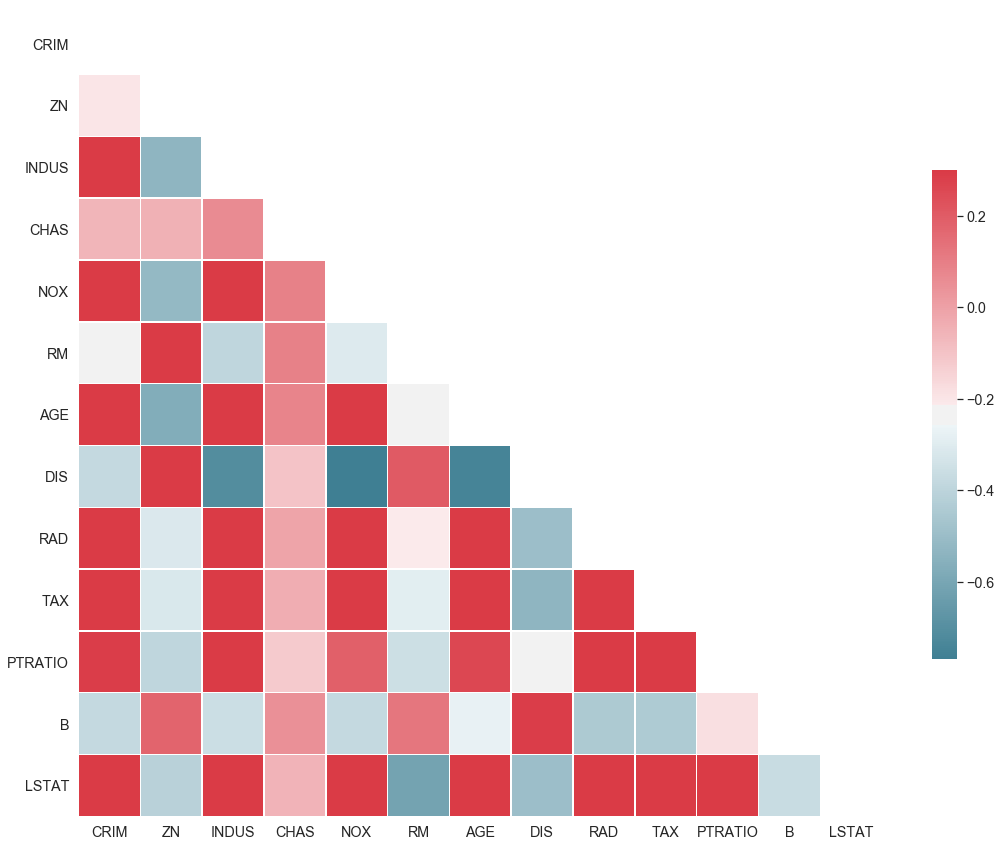

In [11]:
# compute the correlation matrix
corr = X.corr()

# generate a mask for the lower triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 18))

# generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, 
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax);

## Preprocessing

### Splitting the data (train/test)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

There are lots of feature. Let's visualize two of them across the train and test data. 

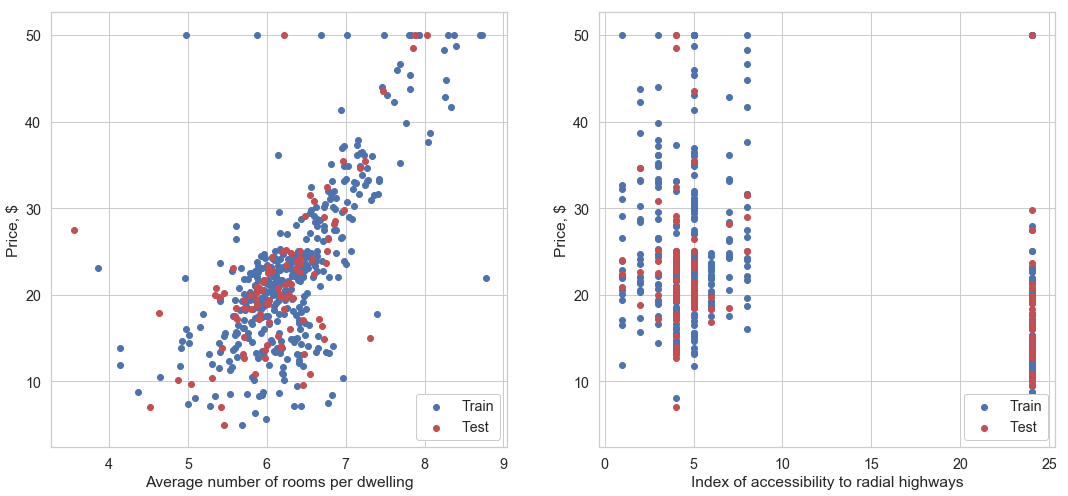

In [13]:
plt.figure(figsize=(18, 8))
plt.subplot(121)
plt.scatter(X_train.RM, y_train, label="Train")
plt.scatter(X_test.RM, y_test, c="r", label="Test")
plt.xlabel("Average number of rooms per dwelling")
plt.ylabel("Price, $")
plt.legend(loc="lower right", frameon=True)
plt.subplot(122)
plt.scatter(X_train.RAD, y_train, label="Train")
plt.scatter(X_test.RAD, y_test, c="r", label="Test")
plt.xlabel("Index of accessibility to radial highways")
plt.ylabel("Price, $")
plt.legend(loc="lower right");

Positive correlation between number of rooms and price

### Scaling

Normalize data in the range $(0,1)$ to make our data insensitive to the scale of features.

In [14]:
scaler = MinMaxScaler()

Note that we're going to learn normalization constants only on training set. That's done because the assumption is that test set is unreachable during training.

In [15]:
X_train = scaler.fit_transform(X_train)

In [20]:
X_train

array([[1.68762759e-01, 0.00000000e+00, 6.42962963e-01, ...,
        8.08510638e-01, 8.80427656e-01, 6.39624724e-01],
       [6.95009416e-03, 0.00000000e+00, 2.74074074e-01, ...,
        8.93617021e-01, 9.96772404e-01, 1.85982340e-01],
       [2.87746689e-04, 3.50000000e-01, 1.97037037e-01, ...,
        4.57446809e-01, 9.12627969e-01, 1.68322296e-01],
       ...,
       [6.68786251e-05, 8.00000000e-01, 4.70370370e-02, ...,
        4.68085106e-01, 9.84971506e-01, 1.17549669e-01],
       [1.25342233e-01, 0.00000000e+00, 6.42962963e-01, ...,
        8.08510638e-01, 2.76186394e-01, 5.94370861e-01],
       [2.46945108e-03, 0.00000000e+00, 2.89629630e-01, ...,
        8.82978723e-01, 1.77719502e-01, 2.45584989e-01]])

Transform test set with the same constants

In [16]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102 entries, 173 to 75
Data columns (total 13 columns):
CRIM       102 non-null float64
ZN         102 non-null float64
INDUS      102 non-null float64
CHAS       102 non-null float64
NOX        102 non-null float64
RM         102 non-null float64
AGE        102 non-null float64
DIS        102 non-null float64
RAD        102 non-null float64
TAX        102 non-null float64
PTRATIO    102 non-null float64
B          102 non-null float64
LSTAT      102 non-null float64
dtypes: float64(13)
memory usage: 11.2 KB


In [17]:
X_test = scaler.transform(X_test)

In [23]:
type(X)

pandas.core.frame.DataFrame

In [24]:
#y.hist()
X.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


/anaconda3/envs/i526/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


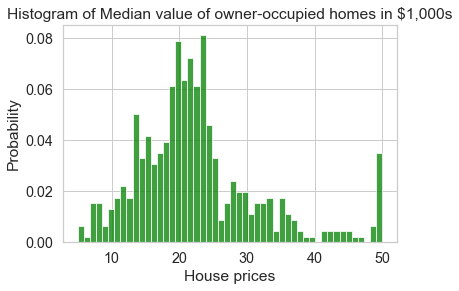

In [25]:

# the histogram of the data
n, bins, patches = plt.hist(y, 50, normed=1, facecolor='green', alpha=0.75)

# add a 'best fit' line
#l = plt.plot(bins, y, 'r--', linewidth=1)

plt.xlabel('House prices')
plt.ylabel('Probability')
plt.title(r'Histogram of Median value of owner-occupied homes in $1,000s')
#plt.axis([40, 160, 0, 0.03])
plt.grid(True)

plt.show()

### Plot distributions of each input variable

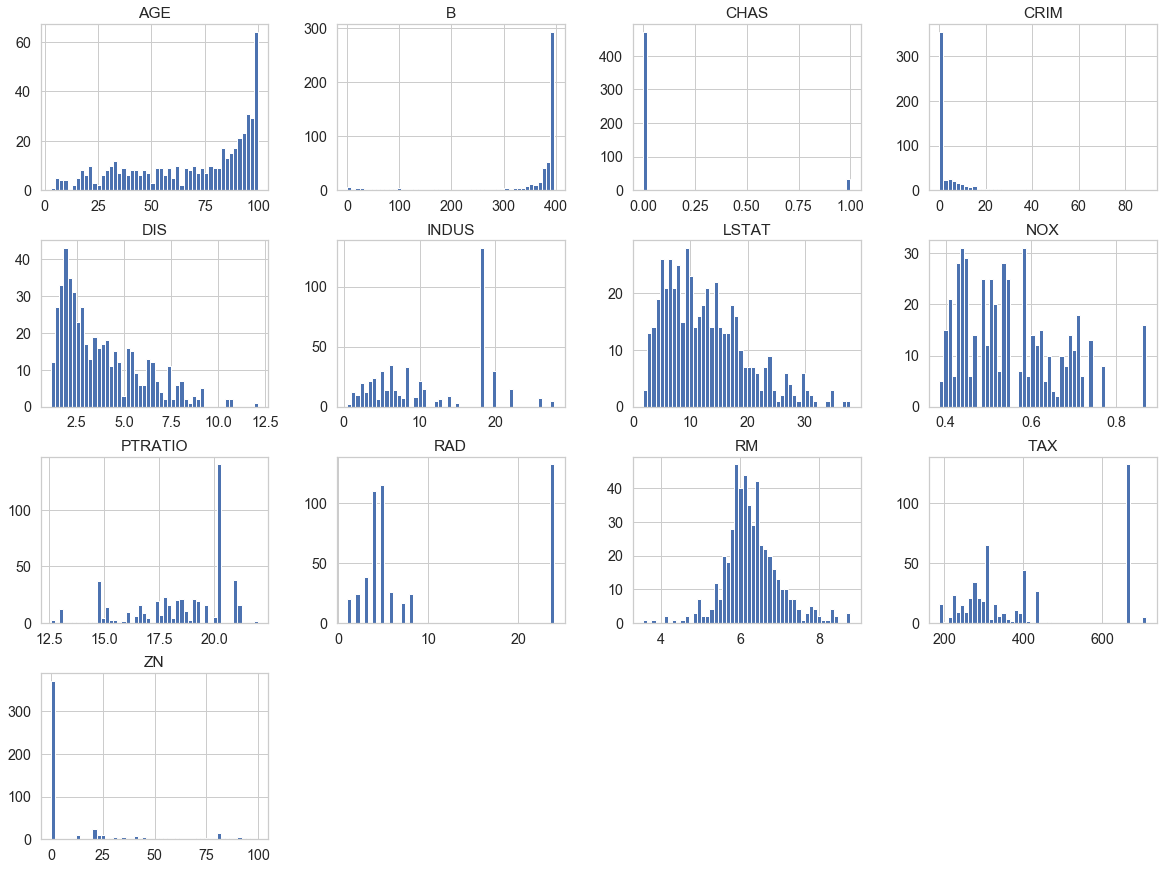

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
X.hist(bins=50, figsize=(20,15))
plt.show()

# Sklearn Linear Regression

## Fitting

Here we use very simple Linear Regression model. Scikit-learn uses the closed-form solition for Linear Regression problem thus it gives very good results.

In [27]:
model_sk = LinearRegression()

Fitting model on prepared data

In [28]:
model_sk.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

## Evaluation

Let's see what features are significant for the model. Largest coefficients will have greatest impact on the model.

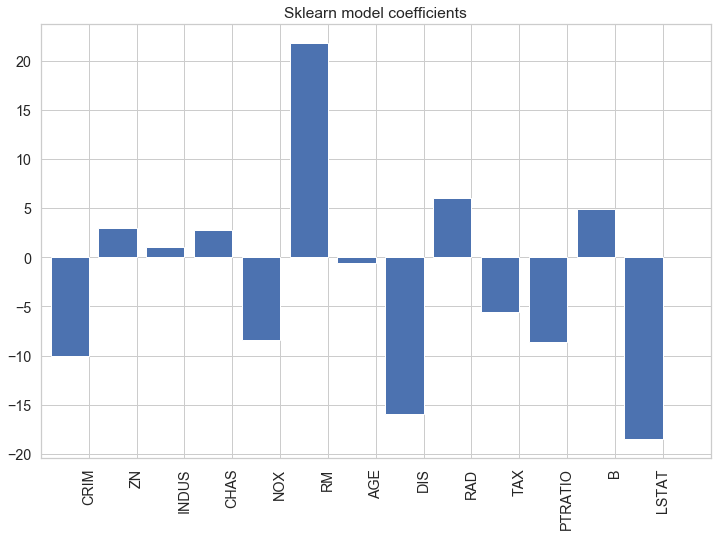

In [29]:
plt.figure(figsize=(12, 8))
plt.bar(np.arange(model_sk.coef_.shape[0]) - 0.4, model_sk.coef_)
plt.xticks(np.arange(model_sk.coef_.shape[0]), X.columns, rotation='vertical')
plt.xlim([-1, model_sk.coef_.shape[0]])
plt.title("Sklearn model coefficients");

Predicting both train and test sets to evaluate model

In [30]:
preds_test = model_sk.predict(X_test)
preds_train = model_sk.predict(X_train)

###  Mean absolute percentage error (MAPE)
There is no MAPE implementation in sklearn (because this metric is undefined when real value is zero). Below one can find my own implementation.

The mean absolute percentage error (MAPE), also known as mean absolute percentage deviation (MAPD), is a measure of prediction accuracy of a forecasting method in statistics, for example in trend estimation. It usually expresses accuracy as a percentage, and is defined by the formula:

$${\displaystyle {\mbox{M}}={\frac {100\%}{n}}\sum _{t=1}^{n}\left|{\frac {A_{t}-F_{t}}{A_{t}}}\right|,} $$
where At is the actual value and Ft is the forecast value.

The difference between At and Ft is divided by the Actual value At again. The absolute value in this calculation is summed for every forecasted point in time and divided by the number of fitted points n. Multiplying by 100% makes it a percentage error.

Although the concept of MAPE sounds very simple and convincing, it has major drawbacks in practical application 

It cannot be used if there are zero values (which sometimes happens for example in demand data) because there would be a division by zero.
For forecasts which are too low the percentage error cannot exceed 100%, but for forecasts which are too high there is no upper limit to the percentage error.
When MAPE is used to compare the accuracy of prediction methods it is biased in that it will systematically select a method whose forecasts are too low. This little-known but serious issue can be overcome by using an accuracy measure based on the ratio of the predicted to actual value (called the Accuracy Ratio), this approach leads to superior statistical properties and leads to predictions which can be interpreted in terms of the geometric mean.

For more details on MAPE please see [here](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error)

In [31]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """
    Use of this metric is not recommended because can cause division by zero
    See other regression metrics on sklearn docs:
      http://scikit-learn.org/stable/modules/classes.html#regression-metrics
    Use like any other metric
    >>> y_true = [3, -0.5, 2, 7]; y_pred = [2.5, -0.3, 2, 8]
    >>> mean_absolute_percentage_error(y_true, y_pred)
    Out[]: 24.791666666666668
    """

    return np.mean(np.abs((y_true.ravel() - y_pred.ravel()) / y_true.ravel())) * 100

Let's evaluate our model according to three different metrics:
* MAE (Mean Absolute Error)
* RMSE (Root Mean Squared Error)
* MAPE (Mean Absolute Percentage Error)

In [32]:
metrics = [mean_absolute_error, 
           lambda y_true, y_pred: mean_squared_error(y_true, y_pred) ** 0.5, 
           mean_absolute_percentage_error]
          #np.std(mean_absolute_error),
          #np.std(lambda y_true, y_pred: mean_squared_error(y_true, y_pred) ** 0.5),
          #np.std(mean_absolute_error)]
metrics_names = ["MAE", 
                 "RMSE", 
                 "MAPE"]
print(metrics_names)

['MAE', 'RMSE', 'MAPE']


Also we want to check quality on both train and test sets

In [33]:
samples = [(X_train, y_train), 
           (X_test, y_test)]
models_names = ["Sklearn"]

Let's do it in loop

In [34]:
models_names = ["Sklearn"]

In [38]:
global stdresults
def evaluate(models, metrics, samples, metrics_names, models_names):
    results = np.zeros((len(samples) * len(models), len(metrics)))
    samples_names = []
    for m in models_names:
        #print('m ', m)
        samples_names.extend([m + " Train", m + " Test"])
        #print(samples_names)
    for m_num, model in enumerate(models):
        #print("m_num",m_num)
        for row, sample in enumerate(samples):
            #print("row",row)
            for col, metric in enumerate(metrics):
                #print("col",col)
                #print("Here",row + m_num * 2, col)
                results[row + m_num * 2, col] = metric(sample[1], model.predict(sample[0]))
                #stdresults[row + m_num * 2, col] = np.std(results[row + m_num * 2, col])
                #print(results)
                #print('stdResults',stdresults)
    results = pd.DataFrame(results, columns=metrics_names, index=samples_names)
    #stdresults = pd.DataFrame(stdresults, columns=metrics_names, index=samples_names)
    #results = pd.DataFrame.append(results,stdresults)
    return results


In [36]:
models = [model_sk]

Evaluated metrics:

In [39]:
evaluate(models, metrics, samples, metrics_names, models_names)

,MAE,RMSE,MAPE
Sklearn Train,3.315165,4.652051,16.573489
Sklearn Test,3.191509,4.930662,16.880585


It is also interesting to take a look how the predicted points relate to real ones. All the points should lie on the black dotted line ($y=x$) assuming that our model is perfect

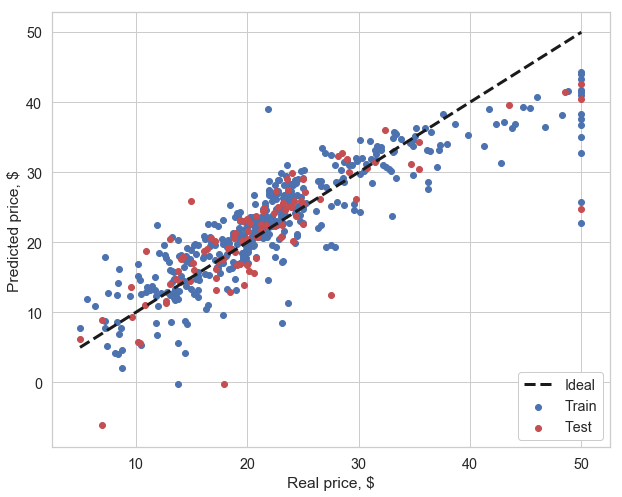

In [40]:
plt.figure(figsize=(10, 8))
plt.scatter(y_train, preds_train, label="Train")
plt.scatter(y_test, preds_test, c="r", label="Test")
plt.xlabel("Real price, $")
plt.ylabel("Predicted price, $")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=3, label="Ideal")
plt.legend(loc="lower right");

## Cross-validation

The common method to evaluate the model is cross-validation. The idea behind it is to divide the whole set of objects into $k$ sections and then use one section as a test set and other $k-1$ as a train (repeat it with all the sections).

There is a special function for this in sklearn called $\text{KFold}$. It creates set of indices for cross-validation.

In [39]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [34]:
cv.n_splits

5

Next step is to do everything that we've done before in a loop:
* Split
* Scale
* Train
* Evaluate

And store the average value of the errors ($\text{res}$ variable)

In [35]:
cv_idx = list(cv.split(X_train, y_train))
#print(cv_idx)

In [36]:

res = None
#i = 0
#j = 0
for train_idx, test_idx in cv_idx:
    # split
    X_train, X_test = X.values[train_idx], X.values[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # scale
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    samples_cv = [(X_train, y_train), 
                  (X_test, y_test)]
    
    # fit
    model_sk_cv = LinearRegression().fit(samples_cv[0][0], samples_cv[0][1])
    
    # evaluate
    if res is None:
        #i+=1
        res = evaluate([model_sk_cv], metrics, samples_cv, metrics_names, ["Sklearn CV"])
        #print(i)
    else:
        #j+=1
        res += evaluate([model_sk_cv], metrics, samples_cv, metrics_names, ["Sklearn CV"])
        #print(i,j)
# take the average value across all folds
res /= cv.n_splits


Here is the result of CV

In [37]:
res

,MAE,RMSE,MAPE
Sklearn CV Train,3.291561,4.732208,14.530076
Sklearn CV Test,3.470811,5.078768,15.284785


# Core Task:  Boston Regression via pipelines 

* Using the Boston dataset from above with data split (i.e., train and blind test split). 
* Repeat the experiment above, change the code to compute the standard deviation of the various metrics.
* Use cross-validation with k=10.
* Report MAE and stdMAE, RMSE and stdRMSE, and MAPE and stdMAPE in a results table (pandas dataframe).

In [41]:
cv = KFold(n_splits=10, shuffle=True, random_state=42)
cv_idx = list(cv.split(X_train, y_train))
print(cv.n_splits)

10


In [52]:
def 
res = None
for train_idx, test_idx in cv_idx:
    # split
    X_train, X_test = X.values[train_idx], X.values[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # scale
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    samples_cv = [(X_train, y_train), 
                  (X_test, y_test)]
    
    # fit
    model_sk_cv = LinearRegression().fit(samples_cv[0][0], samples_cv[0][1])
    
    # evaluate
    if res is None:
        res = evaluate([model_sk_cv], metrics, samples_cv, metrics_names, ["Sklearn CV"])
    else:
        res += evaluate([model_sk_cv], metrics, samples_cv, metrics_names, ["Sklearn CV"])
# take the average value across all folds
res /= cv.n_splits

In [59]:

std_MAElist = None
    #i = 0
    #j = 0
def split_scale_fit():
    for train_idx, test_idx in cv_idx:
        # split
        X_train, X_test = X.values[train_idx], X.values[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # scale
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        samples_cv = [(X_train, y_train), 
                      (X_test, y_test)]
        # fit
        model_sk_cv = LinearRegression().fit(samples_cv[0][0], samples_cv[0][1])
        return model_sk_cv

def ev_fit():
        res = None
        # evaluate     
        if res is None:
            #i+=1
            res = evaluate([model_sk_cv], metrics, samples_cv, metrics_names, ["Sklearn CV"])
            #std_MAElist = res #calculate the std deviation of 
            #print(i)
        else:
            #j+=1
            res += evaluate([model_sk_cv], metrics, samples_cv, metrics_names, ["Sklearn CV"])
            #std_MAElist += res #calculate the std deviation of 
            #print(i,j)
    # take the average value across all folds
        res /= cv.n_splits
        #std_MAE = np.std(res[0])
        #std_RMSE = np.std(res[1])
        #std_MAPE = np.std(res[2])
        #df = 
        #res +=
        return res


In [63]:
from sklearn.pipeline import Pipeline

#('preparation', ......stand),
#SKLearn's linear regression pipeline

pipeline_model = Pipeline([
        ("std_scaler", StandardScaler()),
        ("initial", split_scale_fit())
    ])
#print(preparation_and_feature_selection_pipeline)
pipeline_model.fit(X_train, y_train) 

Pipeline(memory=None,
     steps=[('std_scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('initial', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [65]:
pipeline_model.predict(X_test)

array([-4.00257416e+01, -4.20609437e+00, -6.73077384e+01,  6.34718947e+00,
       -2.18336573e+01,  1.93245161e+01,  1.60340176e+01,  3.65728479e+01,
        9.70866348e+01,  4.69440687e+01, -8.30033584e+00,  2.45490368e+01,
        2.61349557e+01, -2.85176863e+01, -9.21708908e+00,  6.98317731e+01,
        4.42349898e+01,  3.25335766e+01,  8.21052261e+01,  7.33354183e+01,
        9.69889229e+01,  6.72119091e+01, -4.81594824e+01,  3.39522558e+01,
        5.46582696e+01,  1.77030194e+02,  1.17208816e+01,  1.03063564e+02,
        3.51307239e+01,  6.41056355e+01,  4.10570245e+01,  1.85774284e+01,
        5.61001468e+01,  6.63183437e+01,  5.05914659e+01,  4.30739761e+00,
       -1.32867440e-01,  1.13630067e+01, -4.14751453e+01, -1.30378355e+02])

In [62]:
ev_fit()

,MAE,RMSE,MAPE
Sklearn CV Train,0.329573,0.467911,1.522279
Sklearn CV Test,0.367908,0.564527,1.878183


In [ ]:
So, for 10 fold cross-validation set, the 

# Core Task: Predicting Bike Sharing Demand (Kaggle competition)

__This task starts with a lot of background and sample code that you should review, run and experiment with to get familar with this problem and data set. Then, you should complete the tasks posed at the end of this question.__

Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world [as of 2014].

The data generated by these systems makes them attractive for researchers because the duration of travel, departure location, arrival location, and time elapsed is explicitly recorded. Bike sharing systems therefore function as a sensor network, which can be used for studying mobility in a city. In this competition, participants are asked to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.



Overview on the project:

* The objective is to predict the number of bikes that will be rented using the provided  data.
* You will use various python packages like numpy, pandas, seaborn and standardScaler to explore the data and perform feature engineering.
* Finally you will build linear regression models as described in each task and evalaute them using the listed metric(s). 

## Load Data

In [558]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
train=pd.read_csv('Kaggle-Bike-Sharing-Demand-Challenge/train.csv')
test=pd.read_csv('Kaggle-Bike-Sharing-Demand-Challenge/test.csv')

## EDA: Understanding the bike demand data det and doing EDA 

Understanding the Data Set
The dataset shows hourly rental data for two years (2011 and 2012). The training data set is for the first 19 days of each month. The test dataset is from 20th day to month’s end. We are required to predict the total count of bikes rented during each hour covered by the test set.

In the training data set, they have separately given bike demand by registered, casual users and sum of both is given as count.

Training data set has 12 variables (see below) and Test has 9 (excluding registered, casual and count).

Independent Variables

```
datetime:   date and hour in "mm/dd/yyyy hh:mm" format
season:     Four categories-> 1 = spring, 2 = summer, 3 = fall, 4 = winter
holiday:    whether the day is a holiday or not (1/0)
workingday: whether the day is neither a weekend nor holiday (1/0)
weather:    Four Categories of weather
            1-> Clear, Few clouds, Partly cloudy, Partly cloudy
            2-> Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
            3-> Light Snow and Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
            4-> Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
temp:       hourly temperature in Celsius
atemp:      "feels like" temperature in Celsius
humidity:   relative humidity
windspeed:  wind speed
Dependent Variables

registered: number of registered user
casual:     number of non-registered user
count:      number of total rentals (registered + casual)
```
Notice the Training dataset has 3 target features:

```
registered: number of registered user
casual:     number of non-registered user
count:      number of total rentals (registered + casual)
```


** Here we will focus on predicting `count` feature initially.**

In [559]:
print("TRAIN", train.shape)
print("TEST", test.shape)

TRAIN (10886, 12)
TEST (6493, 9)


In [560]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [561]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


### Check if there is any missing value.

In [562]:
train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [563]:
train.describe()  #summary statistics for each variable

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


### Plot the feature distributions (including the targets: count, casual, registered)

In [564]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


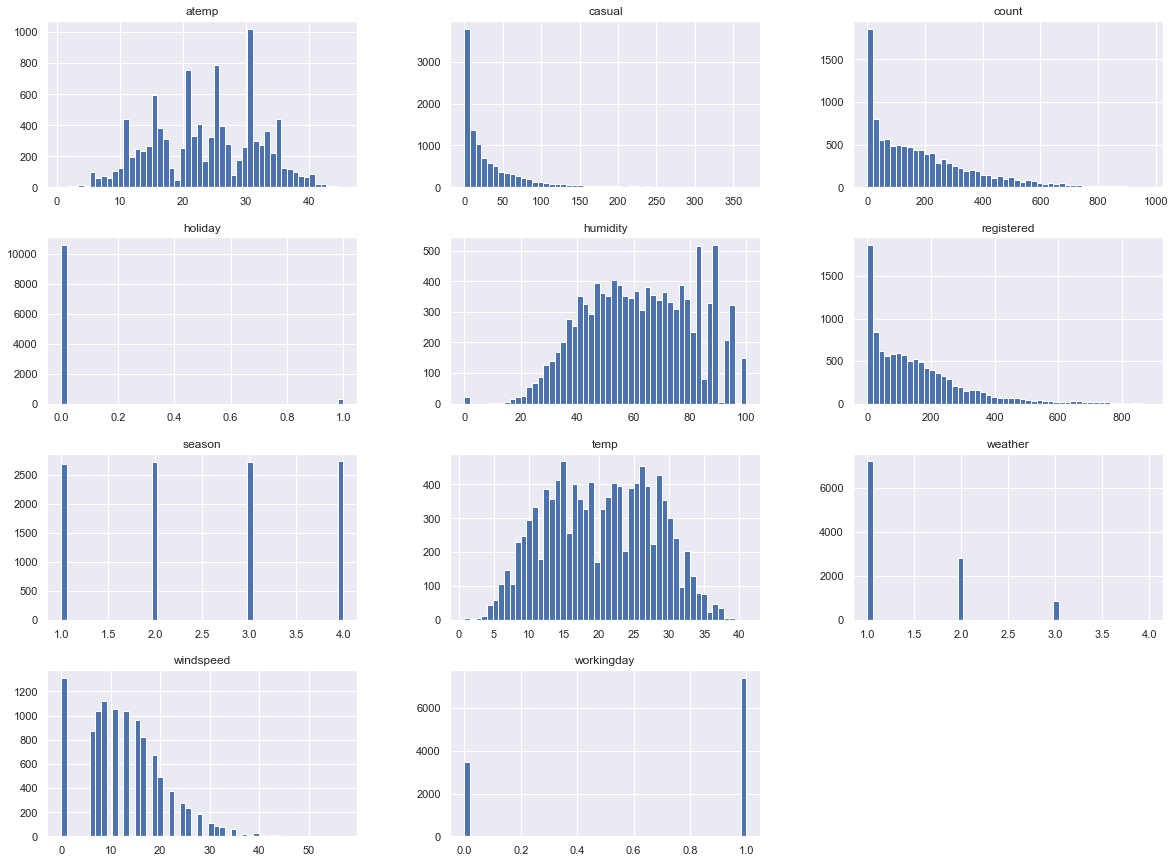

In [565]:
%matplotlib inline
import matplotlib.pyplot as plt
train.hist(bins=50, figsize=(20,15))
plt.show()

### Pandas and Dataframes

In computer programming, `pandas` is a software library written for the Python programming language for data manipulation and analysis. Data is stored in tabular format.  In particular, it offers data structures and operations for manipulating numerical tables and time series. 

The Panda Library features include:

* DataFrame object for data manipulation with integrated indexing.
* Tools for reading and writing data between in-memory data structures and different file formats.
* Data alignment and integrated handling of missing data.
* Reshaping and pivoting of data sets.
* Label-based slicing, fancy indexing, and subsetting of large data sets.
* Data structure column insertion and deletion.
* **Group by engine allowing split-apply-combine operations on data sets.**
* Data set merging and joining.
* Hierarchical axis indexing to work with high-dimensional data in a lower-dimensional data structure.
* Time series-functionality: 
  * Date range generation[3] and frequency conversion, 
  * moving window statistics, 
  * moving window linear regressions, 
  * date shifting and lagging.


For more info on Pandas dataframes see the following:

* [Pandas intro](https://pandas.pydata.org/pandas-docs/stable/dsintro.html)
* [Wiki entry for Pandas](https://en.wikipedia.org/wiki/Pandas_(software))


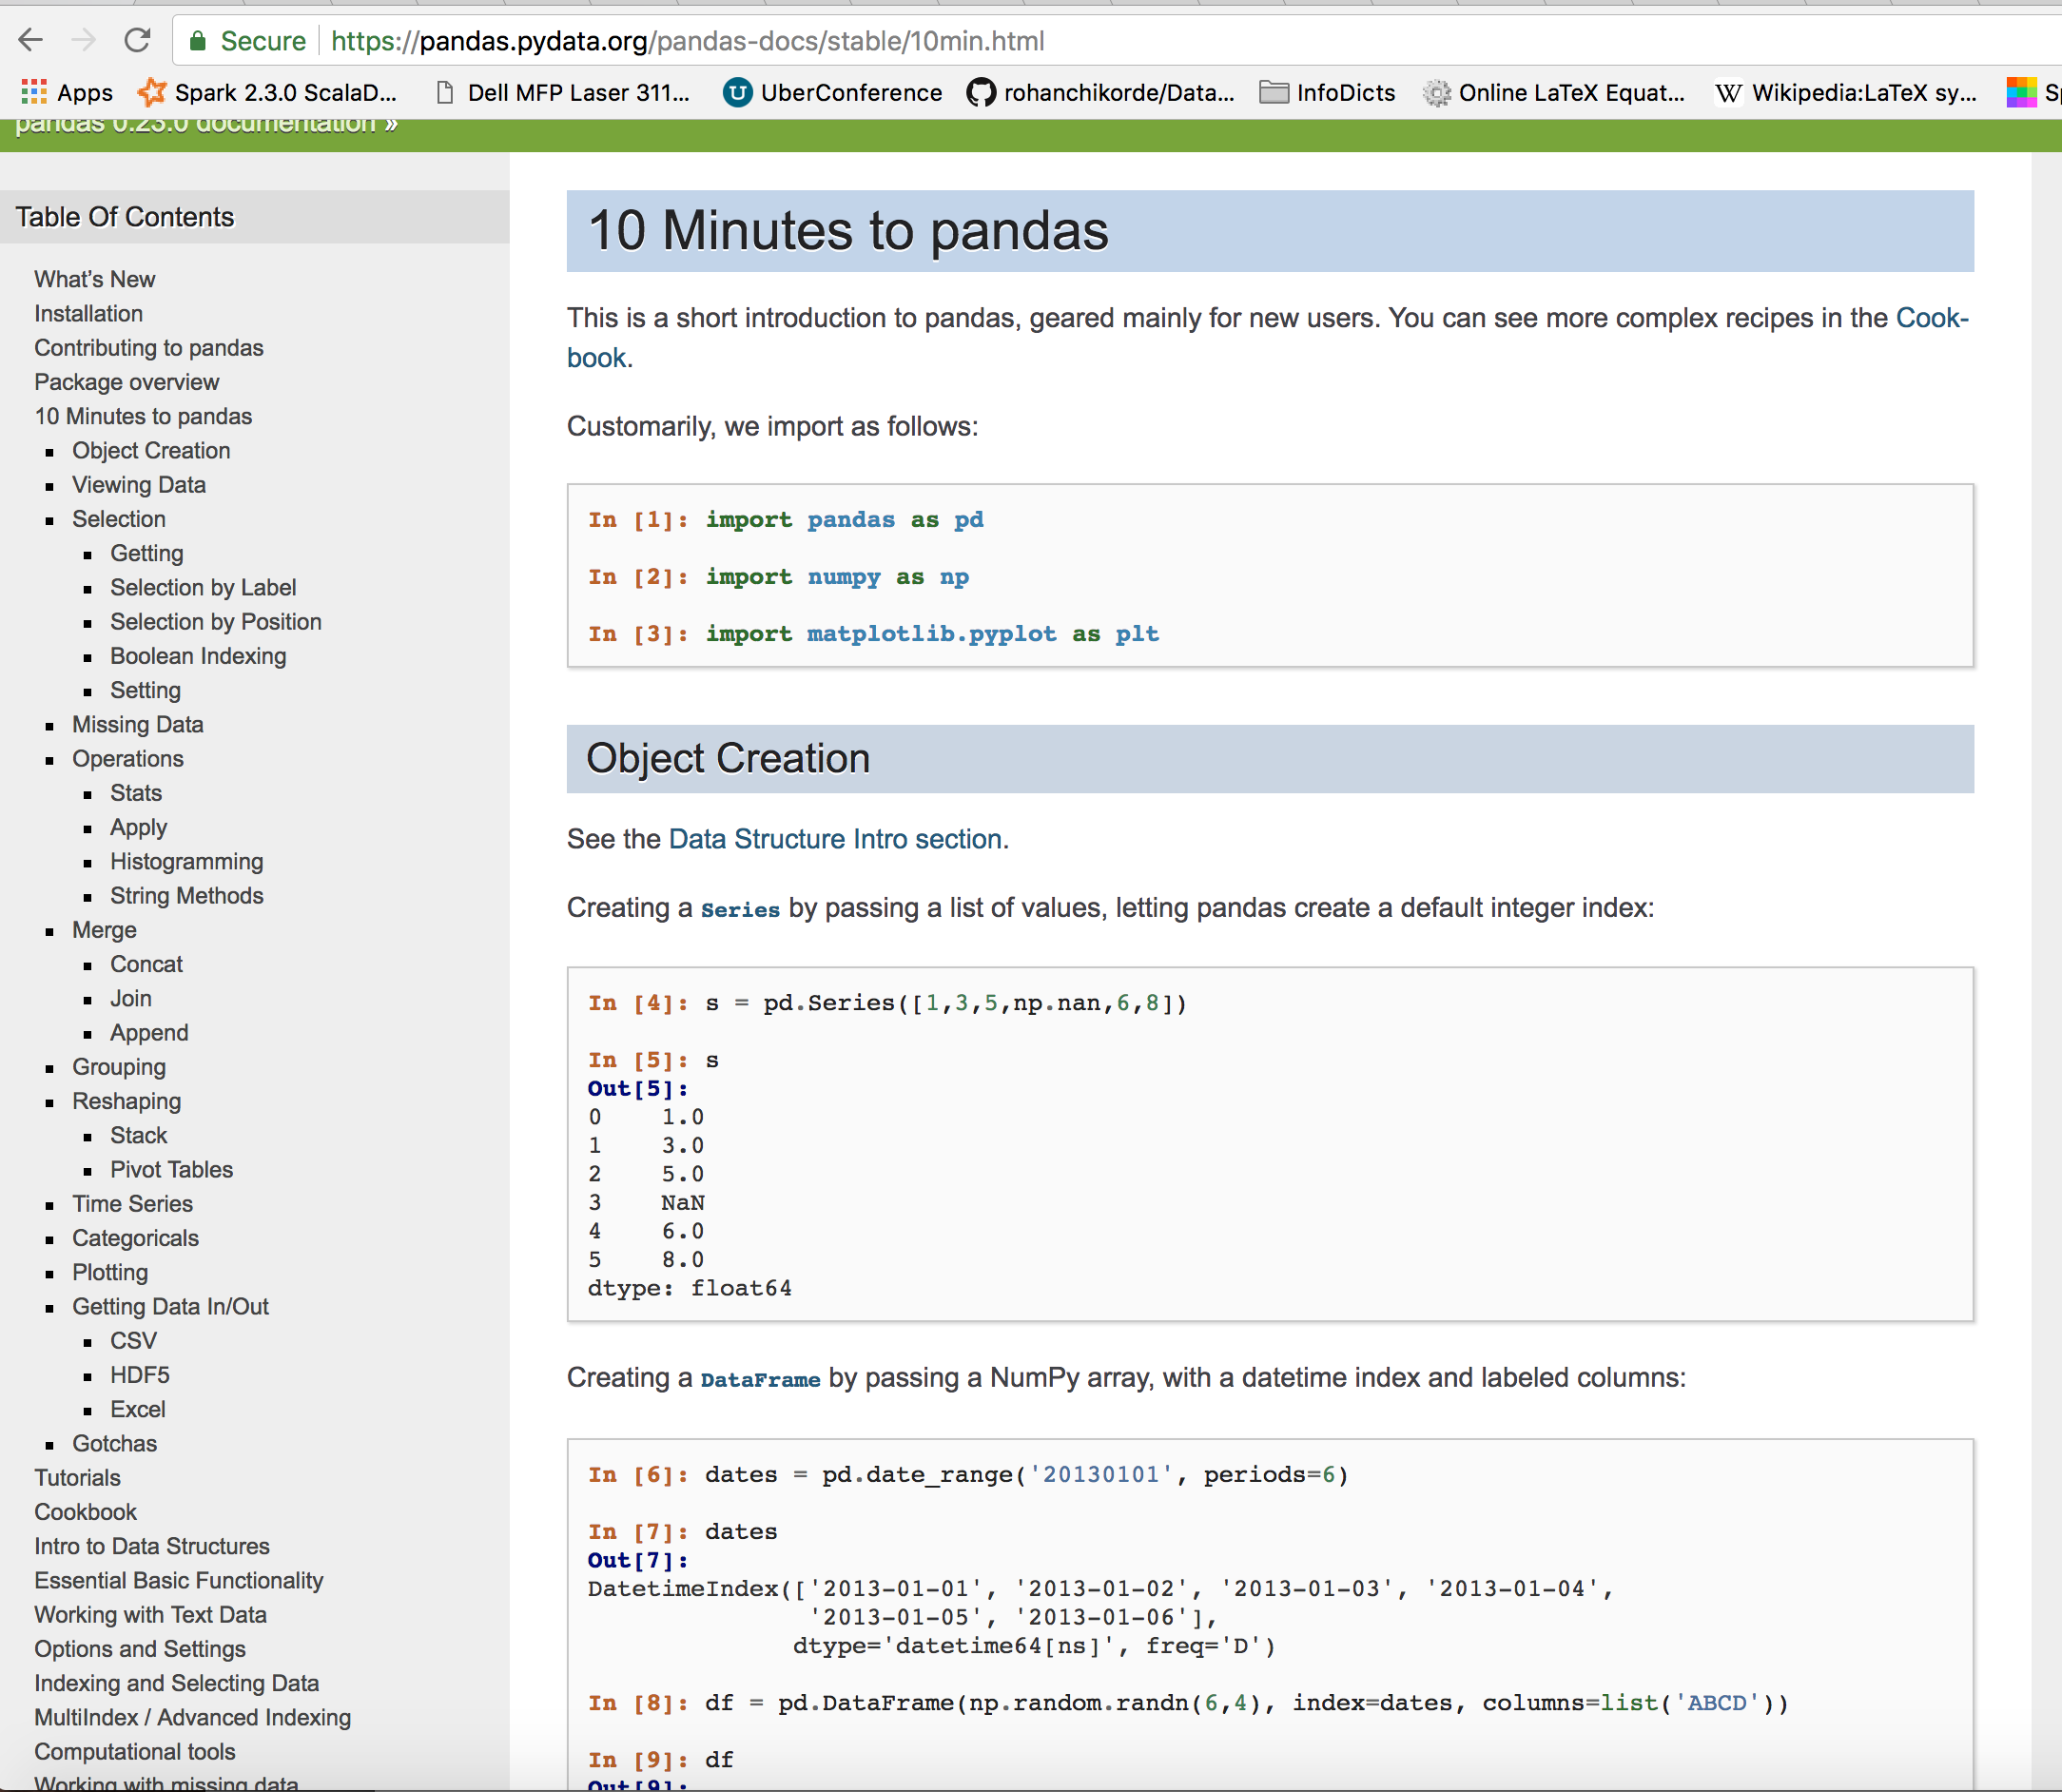



#### GROUP BY analysis: Sample use of a GROUP BY analysis: E.g., Season, or Holiday


E.g., 

* groupby(['holiday']) to see if the target value varies between holiday and not holiday.
* groupby(['season'] to see if the target value varies between different seasons.


In [566]:
train[['count', 'holiday']].groupby(['holiday'], as_index = True).mean().sort_values(by = 'count')

,count
holiday,
1,185.877814
0,191.741655


Since there are an equal number of both holiday and not holiday. We are good with this variable.

In [567]:
train[['count', 'season']].groupby(['season'], as_index = True).mean().sort_values(by = 'count')

,count
season,
1,116.343261
4,198.988296
2,215.251372
3,234.417124


Since the number of examples across different seasons are the same. We can go ahead.

#### Visualize a categorical features like Season, weather 


```
weather:    Four Categories of weather
            1-> Clear, Few clouds, Partly cloudy, Partly cloudy
            2-> Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
            3-> Light Snow and Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
            4-> Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

```

In [568]:
train.season.unique()

array([1, 2, 3, 4])

In [569]:
train.weather.value_counts()

1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64

In [570]:
train.holiday.value_counts()

0    10575
1      311
Name: holiday, dtype: int64

/anaconda3/envs/i526/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


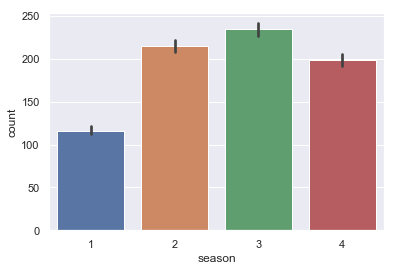

In [571]:
sns.barplot(x='season', y='count', data=train)

/anaconda3/envs/i526/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


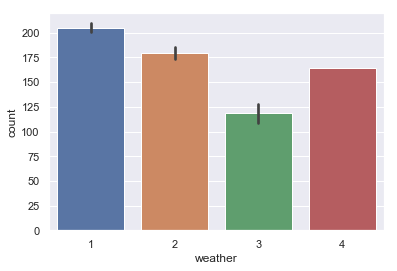

In [572]:
sns.barplot(x='weather', y='count', data=train)

## One hot encoding (OHE)
Features like season, holiday, weather and working day are in  numerical form here. Having said that the numerical values associated with feature like weather dont have any particular numeric ordering. As such, it is much better to one hot encode these features. Here we can do this manually (via code) for training and testing datasets. Later in this course we automate this process in a more principled manner (we have to deal with corner cases.  

* Further, found in the year column, there are just 2 different years 2011,2012 so using map(), we convert  2011 and 2012 to 0 and 1 respectively. 



### OHE on Weather

In [573]:
# Create a new column called df.weather1 where the value is 1
# if df.weather is 1 and 0 if not
train['weather1'] = np.where(train['weather']==1, 1, 0)  #ifelse assignment
train['weather2'] = np.where(train['weather']==2, 1, 0)
train['weather3'] = np.where(train['weather']==3, 1, 0)
train['weather4'] = np.where(train['weather']==4, 1, 0)

# dont forget to drop the original feature
train.drop(['weather'], axis=1, inplace=True)

In [574]:
train.iloc[[7000]] ## Weather has a value of 2

,datetime,season,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,count,weather1,weather2,weather3,weather4
7000,2012-04-10 00:00:00,2,0,1,18.04,21.97,47,19.0012,3,23,26,0,1,0,0


### OHE on Season

OHE on season

In [575]:
# Create a new column called df.seasons1 where the value is 1
# if df.weather is 1 and 0 if not
train['season1'] = np.where(train['season']==1, 1, 0)  #ifelse assignment
train['season2'] = np.where(train['season']==2, 1, 0)
train['season3'] = np.where(train['season']==3, 1, 0)
train['season4'] = np.where(train['season']==4, 1, 0)

# dont forget to drop the original feature
train.drop(['season'], axis=1, inplace=True)

In [576]:
train.iloc[[6000]] ## Season has a value of 1

,datetime,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,count,weather1,weather2,weather3,weather4,season1,season2,season3,season4
6000,2012-02-06 06:00:00,0,1,6.56,9.09,86,7.0015,0,72,72,1,0,0,0,1,0,0,0


## Create new  features (based on timestamp)
* Well, we have a datetime feature (more like an object) in this dataset.  Let's break it into hour, day, month, year and make them a separate column.


In [577]:
train["hour"] = [t.hour for t in pd.DatetimeIndex(train.datetime)]
train["day"] = [t.dayofweek for t in pd.DatetimeIndex(train.datetime)]
train["month"] = [t.month for t in pd.DatetimeIndex(train.datetime)]
train['year'] = [t.year for t in pd.DatetimeIndex(train.datetime)]
train['year'] = train['year'].map({2011:0, 2012:1}) #OHE: One-hot-encoding (OHE): based 

## Separate input features and target feature for TRAIN ONLY.

Why separate input features and target feature for TRAIN only?

Answer: The test set is for creating a Kaggle submission.


In [578]:
X, y = train.iloc[:, 1:], train['count']
X = train.drop(['datetime','registered', 'casual', 'count'], axis=1)

In [579]:
X.iloc[0:2,:]

,holiday,workingday,temp,atemp,humidity,windspeed,weather1,weather2,weather3,weather4,season1,season2,season3,season4,hour,day,month,year
0,0,0,9.84,14.395,81,0.0,1,0,0,0,1,0,0,0,0,5,1,0
1,0,0,9.02,13.635,80,0.0,1,0,0,0,1,0,0,0,1,5,1,0


## Analysis of target variables

It was seen from the training data sum of registered column and casual column yields count.
It was unnecessary to keep these two columns as our features, Machine learning learners can be more fruitful if dataset is free of useless columns.

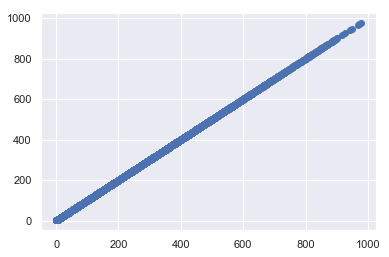

In [580]:
plt.scatter(x = train['casual'] + train['registered'], y = train['count'])
plt.show()

## Applying machine learning models (i.e., linear regression, DTs)

### Split the training data into train and a blind test set 
Split the training data into train and a blind test set using scikit's train_test_split package. Rememeber that the test set that was provided is for Kaggle submission only and as such has not target values.


In [591]:
from sklearn.model_selection import  train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)

Features on larger scales can unduly influence the model.
We want features on a similar scale.
Scikit's preprocessing provides us with StandardScaler package to scale our data.

In [592]:
from sklearn.preprocessing import StandardScaler
import time
scl= StandardScaler()
X_train_std = scl.fit_transform(X_train)
X_test_std = scl.transform(X_test)
start = time.time()
lin_reg = LinearRegression()
lin_reg.fit(X_train_std, y_train) #SKLearn's linear regression
y_train_pred = lin_reg.predict(X_train_std)
train_time = time.time()-start

start = time.time()
y_test_pred = lin_reg.predict(X_test_std)
test_time = time.time()-start

In [593]:
from sklearn.metrics import mean_squared_error, r2_score
#Root_Mean_Square Error(RMSE) is performance criteria for this problem

print('RMSE train: %.3f' % np.sqrt(mean_squared_error(y_train , y_train_pred))) #RMSE on raw count value

# errors on  count
print('RMSE train: %.3f' % np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('RMSE test: %.3f' % np.sqrt(mean_squared_error(y_test + 1, y_test_pred)))
print('R2 train: %.3f' % r2_score(y_train, y_train_pred))
print('R2 test: %.3f' % r2_score(y_test, y_test_pred))
print("MAE train: %.3f" % mean_absolute_error(y_train, y_train_pred))
print("MAE test: %.3f" % mean_absolute_error(y_test, y_test_pred))
print("MAPE train: %.3f" % mean_absolute_percentage_error(y_train, y_train_pred))
print("MAPE test: %.3f" % mean_absolute_percentage_error(y_test, y_test_pred))

RMSE train: 140.858
RMSE train: 140.858
RMSE test: 140.219
R2 train: 0.398
R2 test: 0.395
MAE train: 105.685
MAE test: 105.622
MAPE train: 339.812
MAPE test: 355.454


Text(0.5,1,'loglog base 2 on x')

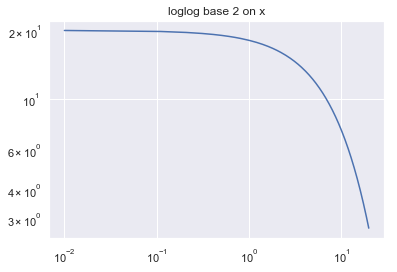

In [594]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

t = np.arange(0.01, 20.0, 0.1)

# log x and y axis
#plt.subplot(223)
plt.loglog(t, 20*np.exp(-t/10.0))# basex=2)
plt.grid(True)
plt.title('loglog base 2 on x')


### Keep a log book to track your experiments

```Model description	RMSLE train	Train Time	RMSLE test	R2 test	Test Time
0	SKLearn Linear Regression vanilla	140.858	0.002356	140.211	0.000176	0.395
```

In [595]:
expLog = pd.DataFrame(columns=["Model description", "RMSE train", "R2 Train",
                               'MAE train', 'MAPE train','Train Time', 
                               'RMSE test','R2 test', 'MAE test', 'MAPE test', 'Test Time'])

# add the result of this experiment ot the log book
expLog.loc[len(expLog)] = ["SKLearn Linear Regression vanilla",
                           np.round(np.sqrt(mean_squared_error(y_train, y_train_pred)),3),
                           np.round(r2_score(y_train, y_train_pred), 3),
                           np.round(mean_absolute_error(y_train, y_train_pred), 3),
                           np.round(mean_absolute_percentage_error(y_train, y_train_pred),3),    
                           train_time,
                           np.round(np.sqrt(mean_squared_error(y_test, y_test_pred)),3),
                           np.round(r2_score(y_test, y_test_pred), 3),                       
                           np.round(mean_absolute_error(y_test, y_test_pred), 3),
                           np.round(mean_absolute_percentage_error(y_test, y_test_pred),3),
                           test_time]
expLog

,Model description,RMSE train,R2 Train,MAE train,MAPE train,Train Time,RMSE test,R2 test,MAE test,MAPE test,Test Time
0,SKLearn Linear Regression vanilla,140.858,0.398,105.685,339.812,0.002435,140.211,0.395,105.622,355.454,0.000162


### Learn a Decision Tree  Regressor
Let's learn a DecisionTreeRegressor model for comparison purposes.

In [596]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor()
start = time.time()
dt.fit(X_train_std, y_train)
y_train_pred = dt.predict(X_train_std)
train_time = time.time() - start

start = time.time()
y_test_pred = dt.predict(X_test_std)
test_time = time.time() - start

#Root_Mean_Square_Log_Error(RMSE) is accuracy criteria for this problem
# errors on  count
print('RMSE train: %.3f' % np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('RMSE test: %.3f' % np.sqrt(mean_squared_error(y_test + 1, y_test_pred)))
print('R2 train: %.3f' % r2_score(y_train, y_train_pred))
print('R2 test: %.3f' % r2_score(y_test, y_test_pred))
print("MAE train: %.3f" % mean_absolute_error(y_train, y_train_pred))
print("MAE test: %.3f" % mean_absolute_error(y_test, y_test_pred))
print("MAPE train: %.3f" % mean_absolute_percentage_error(y_train, y_train_pred))
print("MAPE test: %.3f" % mean_absolute_percentage_error(y_test, y_test_pred))   
      
expLog.loc[len(expLog)] = ["SKLearn Decision Tree",
                           np.round(np.sqrt(mean_squared_error(y_train, y_train_pred)),3),
                           np.round(r2_score(y_train, y_train_pred), 3),
                           np.round(mean_absolute_error(y_train, y_train_pred), 3),
                           np.round(mean_absolute_percentage_error(y_train, y_train_pred),3),    
                           train_time,
                           np.round(np.sqrt(mean_squared_error(y_test, y_test_pred)),3),
                           np.round(r2_score(y_test, y_test_pred), 3),                       
                           np.round(mean_absolute_error(y_test, y_test_pred), 3),
                           np.round(mean_absolute_percentage_error(y_test, y_test_pred),3),
                           test_time]
expLog

RMSE train: 0.276
RMSE test: 62.087
R2 train: 1.000
R2 test: 0.881
MAE train: 0.007
MAE test: 36.238
MAPE train: 0.047
MAPE test: 37.833


,Model description,RMSE train,R2 Train,MAE train,MAPE train,Train Time,RMSE test,R2 test,MAE test,MAPE test,Test Time
0,SKLearn Linear Regression vanilla,140.858,0.398,105.685,339.812,0.002435,140.211,0.395,105.622,355.454,0.000162
1,SKLearn Decision Tree,0.276,1.000,0.007,0.047,0.037741,62.105,0.881,36.238,37.833,0.000919


### Learn a Decision Tree ensmble, i.e., use RandomForestRegressor
Learn Decision Tree ensemble, RandomForestRegressor, model.

In [597]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators = 400, criterion='mse',random_state=1, n_jobs=-1)
start = time.time()
forest.fit(X_train_std, y_train)
y_train_pred = forest.predict(X_train_std)
train_time = time.time() - start

start = time.time()
y_test_pred = forest.predict(X_test_std)
test_time = time.time() - start

In [598]:
from sklearn.metrics import mean_squared_error, r2_score
#Root_Mean_Square_Log_Error(RMSE) is accuracy criteria for this problem
# errors on  count
print('RMSE train: %.3f' % np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('RMSE test: %.3f' % np.sqrt(mean_squared_error(y_test + 1, y_test_pred)))
print('R2 train: %.3f' % r2_score(y_train, y_train_pred))
print('R2 test: %.3f' % r2_score(y_test, y_test_pred))
print("MAE train: %.3f" % mean_absolute_error(y_train, y_train_pred))
print("MAE test: %.3f" % mean_absolute_error(y_test, y_test_pred))
print("MAPE train: %.3f" % mean_absolute_percentage_error(y_train, y_train_pred))
print("MAPE test: %.3f" % mean_absolute_percentage_error(y_test, y_test_pred))   
      
expLog.loc[len(expLog)] = ["SKLearn Random Forest",
                           np.round(np.sqrt(mean_squared_error(y_train, y_train_pred)),3),
                           np.round(r2_score(y_train, y_train_pred), 3),
                           np.round(mean_absolute_error(y_train, y_train_pred), 3),
                           np.round(mean_absolute_percentage_error(y_train, y_train_pred),3),    
                           train_time,
                           np.round(np.sqrt(mean_squared_error(y_test, y_test_pred)),3),
                           np.round(r2_score(y_test, y_test_pred), 3),                       
                           np.round(mean_absolute_error(y_test, y_test_pred), 3),
                           np.round(mean_absolute_percentage_error(y_test, y_test_pred),3),
                           test_time]
expLog

RMSE train: 14.955
RMSE test: 42.512
R2 train: 0.993
R2 test: 0.944
MAE train: 9.161
MAE test: 26.043
MAPE train: 11.024
MAPE test: 31.302


,Model description,RMSE train,R2 Train,MAE train,MAPE train,Train Time,RMSE test,R2 test,MAE test,MAPE test,Test Time
0,SKLearn Linear Regression vanilla,140.858,0.398,105.685,339.812,0.002435,140.211,0.395,105.622,355.454,0.000162
1,SKLearn Decision Tree,0.276,1.000,0.007,0.047,0.037741,62.105,0.881,36.238,37.833,0.000919
2,SKLearn Random Forest,14.955,0.993,9.161,11.024,4.524797,42.532,0.944,26.043,31.302,0.206483


## Generate a submission file on the Kaggle test data.

In [599]:
test=pd.read_csv('./Kaggle-Bike-Sharing-Demand-Challenge/test.csv')
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


### Dont forget to Generate features 

* from datatime object  (hour,day,month,year)
* OHE


In [600]:
# Create a new column called df.weather1 where the value is 1
# if df.weather is 1 and 0 if not
test['weather1'] = np.where(test['weather']==1, 1, 0)  #ifelse assignment
test['weather2'] = np.where(test['weather']==2, 1, 0)
test['weather3'] = np.where(test['weather']==3, 1, 0)
test['weather4'] = np.where(test['weather']==4, 1, 0)

# dont forget to drop the original feature
test.drop(['weather'], axis=1, inplace=True)

In [601]:
test['season1'] = np.where(test['season']==1, 1, 0)  #ifelse assignment
test['season2'] = np.where(test['season']==2, 1, 0)
test['season3'] = np.where(test['season']==3, 1, 0)
test['season4'] = np.where(test['season']==4, 1, 0)
test.drop(['season'], axis=1, inplace=True)

In [602]:
test.head()

,datetime,holiday,workingday,temp,atemp,humidity,windspeed,weather1,weather2,weather3,weather4,season1,season2,season3,season4
0,2011-01-20 00:00:00,0,1,10.66,11.365,56,26.0027,1,0,0,0,1,0,0,0
1,2011-01-20 01:00:00,0,1,10.66,13.635,56,0.0000,1,0,0,0,1,0,0,0
2,2011-01-20 02:00:00,0,1,10.66,13.635,56,0.0000,1,0,0,0,1,0,0,0
3,2011-01-20 03:00:00,0,1,10.66,12.880,56,11.0014,1,0,0,0,1,0,0,0
4,2011-01-20 04:00:00,0,1,10.66,12.880,56,11.0014,1,0,0,0,1,0,0,0


In [603]:
test["hour"] = [t.hour for t in pd.DatetimeIndex(test.datetime)]
test["day"] = [t.dayofweek for t in pd.DatetimeIndex(test.datetime)]
test["month"] = [t.month for t in pd.DatetimeIndex(test.datetime)]
test['year'] = [t.year for t in pd.DatetimeIndex(test.datetime)]
test['year'] = test['year'].map({2011:0, 2012:1})

In [604]:
test.head(4)

,datetime,holiday,workingday,temp,atemp,humidity,windspeed,weather1,weather2,weather3,weather4,season1,season2,season3,season4,hour,day,month,year
0,2011-01-20 00:00:00,0,1,10.66,11.365,56,26.0027,1,0,0,0,1,0,0,0,0,3,1,0
1,2011-01-20 01:00:00,0,1,10.66,13.635,56,0.0000,1,0,0,0,1,0,0,0,1,3,1,0
2,2011-01-20 02:00:00,0,1,10.66,13.635,56,0.0000,1,0,0,0,1,0,0,0,2,3,1,0
3,2011-01-20 03:00:00,0,1,10.66,12.880,56,11.0014,1,0,0,0,1,0,0,0,3,3,1,0


In [605]:
X_test=test.iloc[:,1:]

In [606]:
X_test.head(10)

,holiday,workingday,temp,atemp,humidity,windspeed,weather1,weather2,weather3,weather4,season1,season2,season3,season4,hour,day,month,year
0,0,1,10.66,11.365,56,26.0027,1,0,0,0,1,0,0,0,0,3,1,0
1,0,1,10.66,13.635,56,0.0000,1,0,0,0,1,0,0,0,1,3,1,0
2,0,1,10.66,13.635,56,0.0000,1,0,0,0,1,0,0,0,2,3,1,0
3,0,1,10.66,12.880,56,11.0014,1,0,0,0,1,0,0,0,3,3,1,0
4,0,1,10.66,12.880,56,11.0014,1,0,0,0,1,0,0,0,4,3,1,0
5,0,1,9.84,11.365,60,15.0013,1,0,0,0,1,0,0,0,5,3,1,0
6,0,1,9.02,10.605,60,15.0013,1,0,0,0,1,0,0,0,6,3,1,0
7,0,1,9.02,10.605,55,15.0013,1,0,0,0,1,0,0,0,7,3,1,0
8,0,1,9.02,10.605,55,19.0012,1,0,0,0,1,0,0,0,8,3,1,0
9,0,1,9.84,11.365,52,15.0013,0,1,0,0,1,0,0,0,9,3,1,0


Similarly, use same standarad scaler for test data

In [607]:
X_test = scl.transform(X_test) #X_test_std = scl.transform(X_test)

In [608]:
X_test

array([[-0.17322849,  0.68343061, -1.22171657, ..., -0.0056282 ,
        -1.59591744, -0.99659373],
       [-0.17322849,  0.68343061, -1.22171657, ..., -0.0056282 ,
        -1.59591744, -0.99659373],
       [-0.17322849,  0.68343061, -1.22171657, ..., -0.0056282 ,
        -1.59591744, -0.99659373],
       ...,
       [-0.17322849,  0.68343061, -1.22171657, ..., -1.50168149,
         1.59340616,  1.00341791],
       [-0.17322849,  0.68343061, -1.22171657, ..., -1.50168149,
         1.59340616,  1.00341791],
       [-0.17322849,  0.68343061, -1.22171657, ..., -1.50168149,
         1.59340616,  1.00341791]])

In [609]:
y_test=forest.predict(X_test)

In [610]:
df_submit = test

In [611]:
df_submit['count'] = np.round(y_test)

In [612]:
df_submit.head()

,datetime,holiday,workingday,temp,atemp,humidity,windspeed,weather1,weather2,weather3,weather4,season1,season2,season3,season4,hour,day,month,year,count
0,2011-01-20 00:00:00,0,1,10.66,11.365,56,26.0027,1,0,0,0,1,0,0,0,0,3,1,0,11.0
1,2011-01-20 01:00:00,0,1,10.66,13.635,56,0.0000,1,0,0,0,1,0,0,0,1,3,1,0,6.0
2,2011-01-20 02:00:00,0,1,10.66,13.635,56,0.0000,1,0,0,0,1,0,0,0,2,3,1,0,4.0
3,2011-01-20 03:00:00,0,1,10.66,12.880,56,11.0014,1,0,0,0,1,0,0,0,3,3,1,0,4.0
4,2011-01-20 04:00:00,0,1,10.66,12.880,56,11.0014,1,0,0,0,1,0,0,0,4,3,1,0,3.0


In [613]:
df_submit = df_submit.drop(['season1', 'season2', 'season3','season4', 'holiday', 'workingday','temp', 'atemp', 'humidity', 
                            'windspeed', 'hour', 'day', 'month', 'year', 'weather1', 'weather2',
                            'weather3', 'weather4'], axis=1)

In [614]:
df_submit.head()

,datetime,count
0,2011-01-20 00:00:00,11.0
1,2011-01-20 01:00:00,6.0
2,2011-01-20 02:00:00,4.0
3,2011-01-20 03:00:00,4.0
4,2011-01-20 04:00:00,3.0


### Clip all negative predictions at zero

This is a post processing step to insure that all negative prediction values (we can not have negative bike rentals) are clipped to the value 0.

How many negative counts does your model predict? Plot a histogram using the code below. 



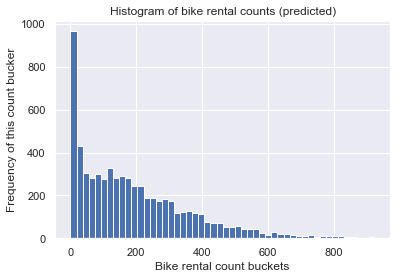

In [615]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import math

# the histogram of the data
n, bins, patches = plt.hist(df_submit['count'], 50)

plt.xlabel('Bike rental count buckets')
plt.ylabel('Frequency of this count bucker')
plt.title(r'Histogram of bike rental counts (predicted)')
plt.grid(True)

plt.show()

In [616]:
df_submit['count'] = np.where(df_submit['count'] < 0, 0, df_submit['count'])

In [617]:
df_submit.to_csv('bike2.csv', index=False)

### Kaggle Submission result

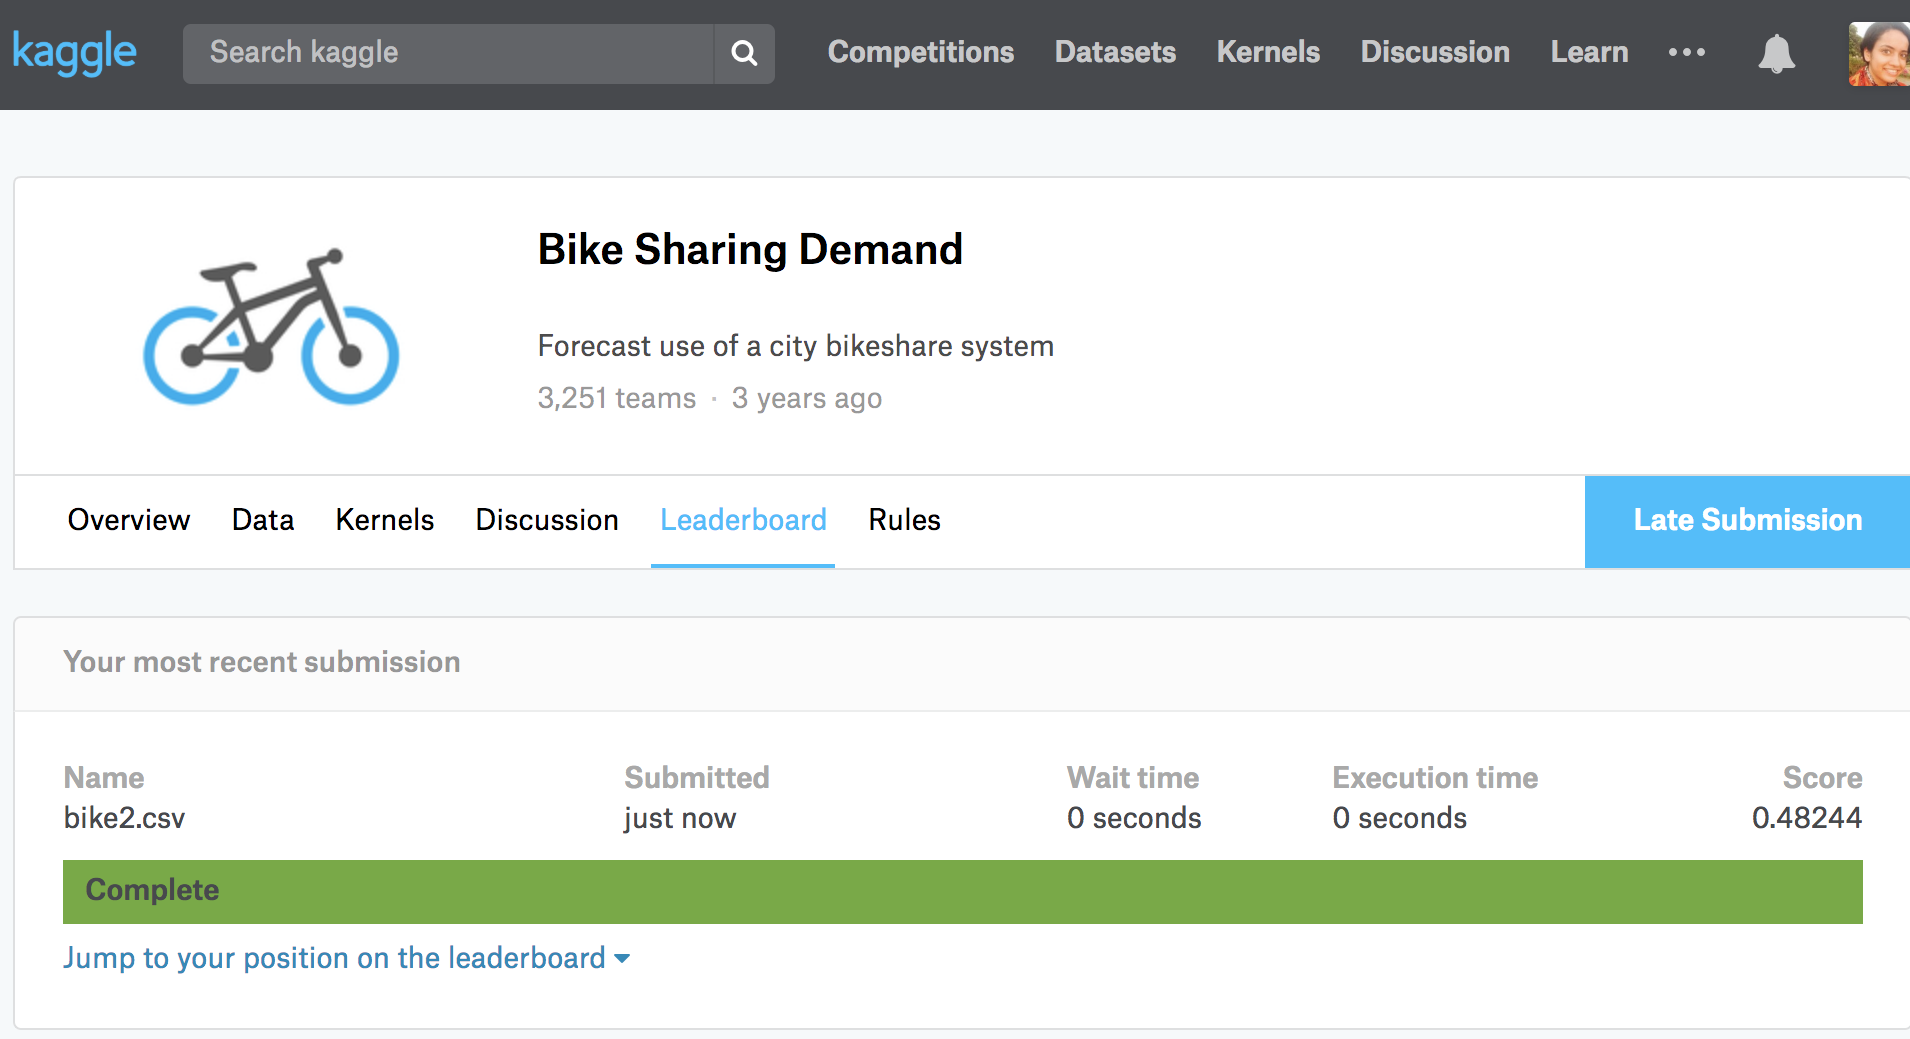

Performed OHE on seasons and weather to predict the bike sharing. 

## CORE TASK: Report your results

Adapt the code and concepts above to build a linear regression model.

__Read and follow these instructions for your submission:__
* Derive new features (e.g., OHE features such as  season). 
* Do feature selection using `SelectKBest` 
  * See Lab04 Notebook for a full section on Feature Selection, including sample code. 
* Put all steps of your model (including Feature Selection) in a Pipeline 
   * __NOTE: please perform the OHE step separate from your pipeline for this homework__
* Present your experimental results in tabular form (using a pandas dataframe). 
  * Describe the linear regression model including number of input features used and types of processing used (e.g., OHE, feature selection).  
  * Report MAE, RMSE and MAPE and run time in your table for each experiment. 
* Do a Kaggle submission with your best linear regression model
* Screenshot your kaggle submission results and paste the screenshot into your notebook submission.
  * Create a markdown cell, paste in the screenshot image and run the cell to convert the link to a graphic.
* Discuss your best result (in terms of process followed, features used and any other interesting discoveries that you came across). 

In [618]:
expLog

,Model description,RMSE train,R2 Train,MAE train,MAPE train,Train Time,RMSE test,R2 test,MAE test,MAPE test,Test Time
0,SKLearn Linear Regression vanilla,140.858,0.398,105.685,339.812,0.002435,140.211,0.395,105.622,355.454,0.000162
1,SKLearn Decision Tree,0.276,1.000,0.007,0.047,0.037741,62.105,0.881,36.238,37.833,0.000919
2,SKLearn Random Forest,14.955,0.993,9.161,11.024,4.524797,42.532,0.944,26.043,31.302,0.206483


In [619]:
X_train.shape

(7620, 18)

In [620]:
X_train.columns.values

array(['holiday', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed',
       'weather1', 'weather2', 'weather3', 'weather4', 'season1',
       'season2', 'season3', 'season4', 'hour', 'day', 'month', 'year'],
      dtype=object)

### RE-run Select K Best for Bike Sharing

In [621]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_regression

# SCORE  linear regression input variables using correlation producing F scores and corresponding p-values
# K is used select top k rated input features
def select_kbest_reg(data_frame, target, k=5):
    """
    Selecting K-Best features regression
    :param data_frame: A pandas dataFrame with the training data
    :param target: target variable name in DataFrame
    :param k: desired number of features from the data
    :returns feature_scores: scores for each feature in the data as 
    pandas DataFrame
    """
    feat_selector = SelectKBest(f_regression, k=k)
    _ = feat_selector.fit(data_frame.drop(target, axis=1), data_frame[target])
    
    feat_scores = pd.DataFrame()
    feat_scores["F Score"] = feat_selector.scores_
    feat_scores["P Value"] = feat_selector.pvalues_
    feat_scores["Support"] = feat_selector.get_support()
    feat_scores["Attribute"] = data_frame.drop(target, axis=1).columns
    
    return feat_scores

df = pd.DataFrame(X_train).copy()

df["label"] = y_train

per_feat = select_kbest_reg(df, 'label', k=12)
per_feat_sorted = per_feat.sort_values(["F Score", "P Value"], ascending=[False, False])
top_k_feature_indices = per_feat_sorted['Attribute'].values.flatten()
print("\n Feature Score for a linear regression using correlation\n")
print(per_feat_sorted)   ##INDUS, RM, TAX, PTRATIO, LSAT

print(np.linalg.norm(y_train))


 Feature Score for a linear regression using correlation

        F Score        P Value  Support   Attribute
14  1469.911208  3.154155e-294     True        hour
2   1392.705790  4.188766e-280     True        temp
3   1345.313872  2.248222e-271     True       atemp
4    835.773721  1.817225e-174     True    humidity
17   521.712886  9.528069e-112     True        year
10   454.819272   4.547750e-98     True     season1
16   230.585036   2.494882e-51     True       month
12   136.114875   3.464712e-31     True     season3
8    107.764635   4.446058e-25     True    weather3
6     85.064471   3.675809e-20     True    weather1
5     76.400544   2.815192e-18     True   windspeed
11    42.362122   8.064916e-11     True     season2
7     12.939829   3.237028e-04    False    weather2
13     6.961529   8.345025e-03    False     season4
1      1.910518   1.669462e-01    False  workingday
15     1.866755   1.718875e-01    False         day
0      0.033480   8.548221e-01    False     holiday
9    

* **So, now we will go with top 12 features. Apart from the F-Score, it is logical to do so as we don't need all the 4 variables from OHE. (If all season 1, 2, and 3 are '0' then it means season4 is '1')**

```        F Score        P Value  Support   Attribute
14  1469.911208  3.154155e-294     True        hour
2   1392.705790  4.188766e-280     True        temp
3   1345.313872  2.248222e-271     True       atemp
4    835.773721  1.817225e-174     True    humidity
17   521.712886  9.528069e-112     True        year
10   454.819272   4.547750e-98     True     season1
16   230.585036   2.494882e-51     True       month
12   136.114875   3.464712e-31     True     season3
8    107.764635   4.446058e-25     True    weather3
6     85.064471   3.675809e-20     True    weather1
5     76.400544   2.815192e-18     True   windspeed
11    42.362122   8.064916e-11     True     season2
```

In [622]:
feature_importances = per_feat[["F Score", "Attribute"]] #Order of appearence in dataframe
feature_importances_sorted = per_feat_sorted[["F Score", "Attribute"]] #Order of appearence in dataframe
feature_importances

,F Score,Attribute
0,0.033480,holiday
1,1.910518,workingday
2,1392.705790,temp
3,1345.313872,atemp
4,835.773721,humidity
5,76.400544,windspeed
6,85.064471,weather1
7,12.939829,weather2
8,107.764635,weather3
9,0.021070,weather4


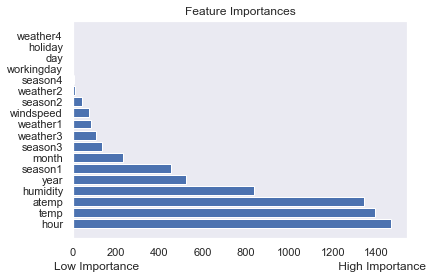

In [314]:
# Plot the feature importances of the forest
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.figure() 
plt.title("Feature importances")
sortedNames = np.array(feature_importances_sorted)[:, 1]
sortedImportances = np.array(feature_importances_sorted)[:, 0]

plt.title('Feature Importances')
plt.barh(range(len(sortedNames)), sortedImportances, color='b', align='center')
plt.yticks(range(len(sortedNames)), sortedNames)
plt.xlabel('Low Importance                                                           High Importance')
plt.grid()
plt.show()

### Feature selection within a Pipeline for Bike Sharing

In [623]:
from sklearn.base import BaseEstimator, TransformerMixin

# find the indices to the top ranking input features based on importance 
#    arr is an array of feature importances in order of the input data matrix X
#    k is the number of features to be selected
#
# Note: this feature selector assumes that you have already computed the feature importances 
# somehow (for example using SelectKBest or through a RandomForestRegressor decision tree ensemble). 
def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    # select the columns of data matrix of the selected input features 
    def transform(self, X):
        return X[:, self.feature_indices_]

In [634]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
#A closer look at TopFeatureSelector
k=7
featureScores = feature_importances[["F Score"]].values.flatten()
tf = TopFeatureSelector(featureScores, k)
tf.fit(X_train)
print(tf.feature_indices_)
#X_train[:,tf.feature_indices_]
X_train.values[:,tf.feature_indices_]
#X_train.info
#type(X)

[ 2  3  4 10 14 16 17]


array([[32.8  , 37.12 , 52.   , ..., 13.   ,  8.   ,  1.   ],
       [32.8  , 35.605, 36.   , ..., 18.   ,  8.   ,  1.   ],
       [ 4.92 ,  6.82 , 50.   , ...,  9.   ,  2.   ,  1.   ],
       ...,
       [27.06 , 31.06 , 39.   , ..., 14.   , 10.   ,  1.   ],
       [14.76 , 17.425, 87.   , ...,  9.   , 12.   ,  1.   ],
       [33.62 , 35.605, 30.   , ..., 18.   ,  7.   ,  0.   ]])

In [635]:
featureScores = feature_importances[["F Score"]].values.flatten()
k=7
preparation_and_feature_selection_pipeline = Pipeline([
    #('preparation', ......stand),
    ("std_scaler", StandardScaler()),
    ('feature_selection', TopFeatureSelector(featureScores, k)) 
]) 
    
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(X_train.values)

In [636]:
housing_prepared_top_k_features[0:3]

array([[ 1.62612244,  1.60195841, -0.51430022, -0.57674413,  0.20987572,
         0.43365212,  1.00341791],
       [ 1.62612244,  1.42280637, -1.34479894, -0.57674413,  0.93071455,
         0.43365212,  1.00341791],
       [-1.9600452 , -1.98108231, -0.61811256,  1.73387115, -0.36679534,
        -1.30597893,  1.00341791]])

In [637]:
X_train.values[0:3, tf.feature_indices_]   # What happened? HINT standardization

array([[32.8  , 37.12 , 52.   ,  0.   , 13.   ,  8.   ,  1.   ],
       [32.8  , 35.605, 36.   ,  0.   , 18.   ,  8.   ,  1.   ],
       [ 4.92 ,  6.82 , 50.   ,  1.   ,  9.   ,  2.   ,  1.   ]])

### Feature Engineering and Prediction

In [638]:
#Above steps is to double-check. Now, FS+pipeline starts
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
#('preparation', ......stand),
#SKLearn's linear regression pipeline
k=7
featureScores = feature_importances[["F Score"]].values.flatten()
preparation_and_feature_selection_pipeline = Pipeline([
        ("std_scaler", StandardScaler()),
        ('feature_selection', TopFeatureSelector(featureScores, k)),
        ('lineReg', LinearRegression())
    ])
#print(preparation_and_feature_selection_pipeline)
preparation_and_feature_selection_pipeline.fit(X_train.values, y_train) 


Pipeline(memory=None,
     steps=[('std_scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('feature_selection', TopFeatureSelector(feature_importances=array([3.34800e-02, 1.91052e+00, 1.39271e+03, 1.34531e+03, 8.35774e+02,
       7.64005e+01, 8.50645e+01, 1.29398e+01, 1.07765e+02, 2.10697e-02,
       4.54819...   k=7)), ('lineReg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

### Metric calculation

In [639]:
#Calculate stuff for metrics
y_train_pred = preparation_and_feature_selection_pipeline.predict(X_train)
train_time = time.time()-start

start = time.time()
y_test_pred = preparation_and_feature_selection_pipeline.predict(X_test)
test_time = time.time()-start

#Root_Mean_Square_Log_Error(RMSE) is accuracy criteria for this problem
# errors on  count
print('RMSE train: %.3f' % np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('RMSE test: %.3f' % np.sqrt(mean_squared_error(y_test + 1, y_test_pred)))
print('R2 train: %.3f' % r2_score(y_train, y_train_pred))
print('R2 test: %.3f' % r2_score(y_test+1, y_test_pred))
print("MAE train: %.3f" % mean_absolute_error(y_train, y_train_pred))
print("MAE test: %.3f" % mean_absolute_error(y_test, y_test_pred))
print("MAPE train: %.3f" % mean_absolute_percentage_error(y_train, y_train_pred))
print("MAPE test: %.3f" % mean_absolute_percentage_error(y_test, y_test_pred))   

RMSE train: 141.953
RMSE test: 238.469
R2 train: 0.388
R2 test: -0.893
MAE train: 106.298
MAE test: 190.769
MAPE train: 336.122
MAPE test: 290.431


In [640]:
expLog.loc[len(expLog)] = ["SKLearn KBest LR, k=7",
                           np.round(np.sqrt(mean_squared_error(y_train, y_train_pred)),3),
                           np.round(r2_score(y_train, y_train_pred), 3),
                           np.round(mean_absolute_error(y_train, y_train_pred), 3),
                           np.round(mean_absolute_percentage_error(y_train, y_train_pred),3),    
                           train_time,
                           np.round(np.sqrt(mean_squared_error(y_test, y_test_pred)),3),
                           np.round(r2_score(y_test+1, y_test_pred), 3),                       
                           np.round(mean_absolute_error(y_test, y_test_pred), 3),
                           np.round(mean_absolute_percentage_error(y_test, y_test_pred),3),
                           test_time]
expLog

,Model description,RMSE train,R2 Train,MAE train,MAPE train,Train Time,RMSE test,R2 test,MAE test,MAPE test,Test Time
0,SKLearn Linear Regression vanilla,140.858,0.398,105.685,339.812,0.002435,140.211,0.395,105.622,355.454,0.000162
1,SKLearn Decision Tree,0.276,1.000,0.007,0.047,0.037741,62.105,0.881,36.238,37.833,0.000919
2,SKLearn Random Forest,14.955,0.993,9.161,11.024,4.524797,42.532,0.944,26.043,31.302,0.206483
3,SKLearn KBest LR,140.872,0.398,105.573,339.399,323.992354,297.788,-1.952,245.430,381.917,0.001200
4,"SKLearn KBest LR, k=7",141.953,0.388,106.298,336.122,119.289571,237.734,-0.893,190.769,290.431,0.001422


In [ ]:
I chose k = 7 as it is som

### Let's fit the model to the entire training set

In [641]:
preparation_and_feature_selection_pipeline.fit(X,train['count']) 

Pipeline(memory=None,
     steps=[('std_scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('feature_selection', TopFeatureSelector(feature_importances=array([3.34800e-02, 1.91052e+00, 1.39271e+03, 1.34531e+03, 8.35774e+02,
       7.64005e+01, 8.50645e+01, 1.29398e+01, 1.07765e+02, 2.10697e-02,
       4.54819...   k=7)), ('lineReg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [642]:
test_1=pd.read_csv('./Kaggle-Bike-Sharing-Demand-Challenge/test.csv')
test_1.head()

### Dont forget to Generate features and 


# Create a new column called df.weather1 where the value is 1
# if df.weather is 1 and 0 if not
test_1['weather1'] = np.where(test_1['weather']==1, 1, 0)  #ifelse assignment
test_1['weather2'] = np.where(test_1['weather']==2, 1, 0)
test_1['weather3'] = np.where(test_1['weather']==3, 1, 0)
test_1['weather4'] = np.where(test_1['weather']==4, 1, 0)

# dont forget to drop the original feature
test_1.drop(['weather'], axis=1, inplace=True)

test_1['season1'] = np.where(test_1['season']==1, 1, 0)  #ifelse assignment
test_1['season2'] = np.where(test_1['season']==2, 1, 0)
test_1['season3'] = np.where(test_1['season']==3, 1, 0)
test_1['season4'] = np.where(test_1['season']==4, 1, 0)
test_1.drop(['season'], axis=1, inplace=True)


test_1["hour"] = [t.hour for t in pd.DatetimeIndex(test_1.datetime)]
test_1["day"] = [t.dayofweek for t in pd.DatetimeIndex(test_1.datetime)]
test_1["month"] = [t.month for t in pd.DatetimeIndex(test_1.datetime)]
test_1['year'] = [t.year for t in pd.DatetimeIndex(test_1.datetime)]
test_1['year'] = test_1['year'].map({2011:0, 2012:1})


X_test1=test_1.iloc[:,1:]

X_test1.head(10)

,holiday,workingday,temp,atemp,humidity,windspeed,weather1,weather2,weather3,weather4,season1,season2,season3,season4,hour,day,month,year
0,0,1,10.66,11.365,56,26.0027,1,0,0,0,1,0,0,0,0,3,1,0
1,0,1,10.66,13.635,56,0.0000,1,0,0,0,1,0,0,0,1,3,1,0
2,0,1,10.66,13.635,56,0.0000,1,0,0,0,1,0,0,0,2,3,1,0
3,0,1,10.66,12.880,56,11.0014,1,0,0,0,1,0,0,0,3,3,1,0
4,0,1,10.66,12.880,56,11.0014,1,0,0,0,1,0,0,0,4,3,1,0
5,0,1,9.84,11.365,60,15.0013,1,0,0,0,1,0,0,0,5,3,1,0
6,0,1,9.02,10.605,60,15.0013,1,0,0,0,1,0,0,0,6,3,1,0
7,0,1,9.02,10.605,55,15.0013,1,0,0,0,1,0,0,0,7,3,1,0
8,0,1,9.02,10.605,55,19.0012,1,0,0,0,1,0,0,0,8,3,1,0
9,0,1,9.84,11.365,52,15.0013,0,1,0,0,1,0,0,0,9,3,1,0


### Let's predict

In [643]:
# let's try the full pipeline on a few testing instances
#X_test = scl.transform(X_test)

predictions = preparation_and_feature_selection_pipeline.predict(X_test1)

print("Predictions:", predictions)

Predictions: [-41.71097438 -24.74018152 -16.90781307 ... 271.88460726 291.52153697
 279.63236437]


In [644]:
df_submit = test_1

df_submit['count'] = np.round(predictions)

In [645]:
df_submit.head()

,datetime,holiday,workingday,temp,atemp,humidity,windspeed,weather1,weather2,weather3,weather4,season1,season2,season3,season4,hour,day,month,year,count
0,2011-01-20 00:00:00,0,1,10.66,11.365,56,26.0027,1,0,0,0,1,0,0,0,0,3,1,0,-42.0
1,2011-01-20 01:00:00,0,1,10.66,13.635,56,0.0000,1,0,0,0,1,0,0,0,1,3,1,0,-25.0
2,2011-01-20 02:00:00,0,1,10.66,13.635,56,0.0000,1,0,0,0,1,0,0,0,2,3,1,0,-17.0
3,2011-01-20 03:00:00,0,1,10.66,12.880,56,11.0014,1,0,0,0,1,0,0,0,3,3,1,0,-12.0
4,2011-01-20 04:00:00,0,1,10.66,12.880,56,11.0014,1,0,0,0,1,0,0,0,4,3,1,0,-4.0


In [646]:
df_submit = df_submit.drop(['season1', 'season2', 'season3','season4', 'holiday', 'workingday','temp', 'atemp', 'humidity', 
                            'windspeed', 'hour', 'day', 'month', 'year', 'weather1', 'weather2',
                            'weather3', 'weather4'], axis=1)

df_submit.head()

,datetime,count
0,2011-01-20 00:00:00,-42.0
1,2011-01-20 01:00:00,-25.0
2,2011-01-20 02:00:00,-17.0
3,2011-01-20 03:00:00,-12.0
4,2011-01-20 04:00:00,-4.0


### Clip all negative results

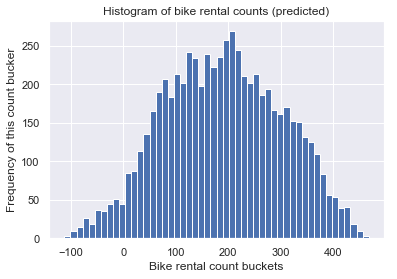

In [647]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import math

# the histogram of the data
n, bins, patches = plt.hist(df_submit['count'], 50)

plt.xlabel('Bike rental count buckets')
plt.ylabel('Frequency of this count bucker')
plt.title(r'Histogram of bike rental counts (predicted)')
plt.grid(True)

plt.show()

In [648]:
df_submit['count'] = np.where(df_submit['count'] < 0, 0, df_submit['count'])

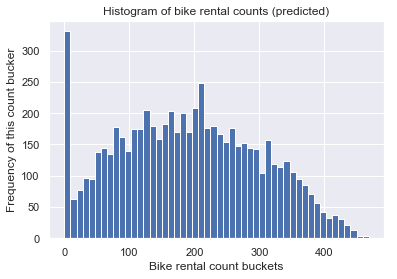

In [649]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import math

# the histogram of the data
n, bins, patches = plt.hist(df_submit['count'], 50)

plt.xlabel('Bike rental count buckets')
plt.ylabel('Frequency of this count bucker')
plt.title(r'Histogram of bike rental counts (predicted)')
plt.grid(True)

plt.show()

Looks good!

In [650]:
df_submit.to_csv('bike_lr_new.csv', index=False)

### Kaggle Submission Result

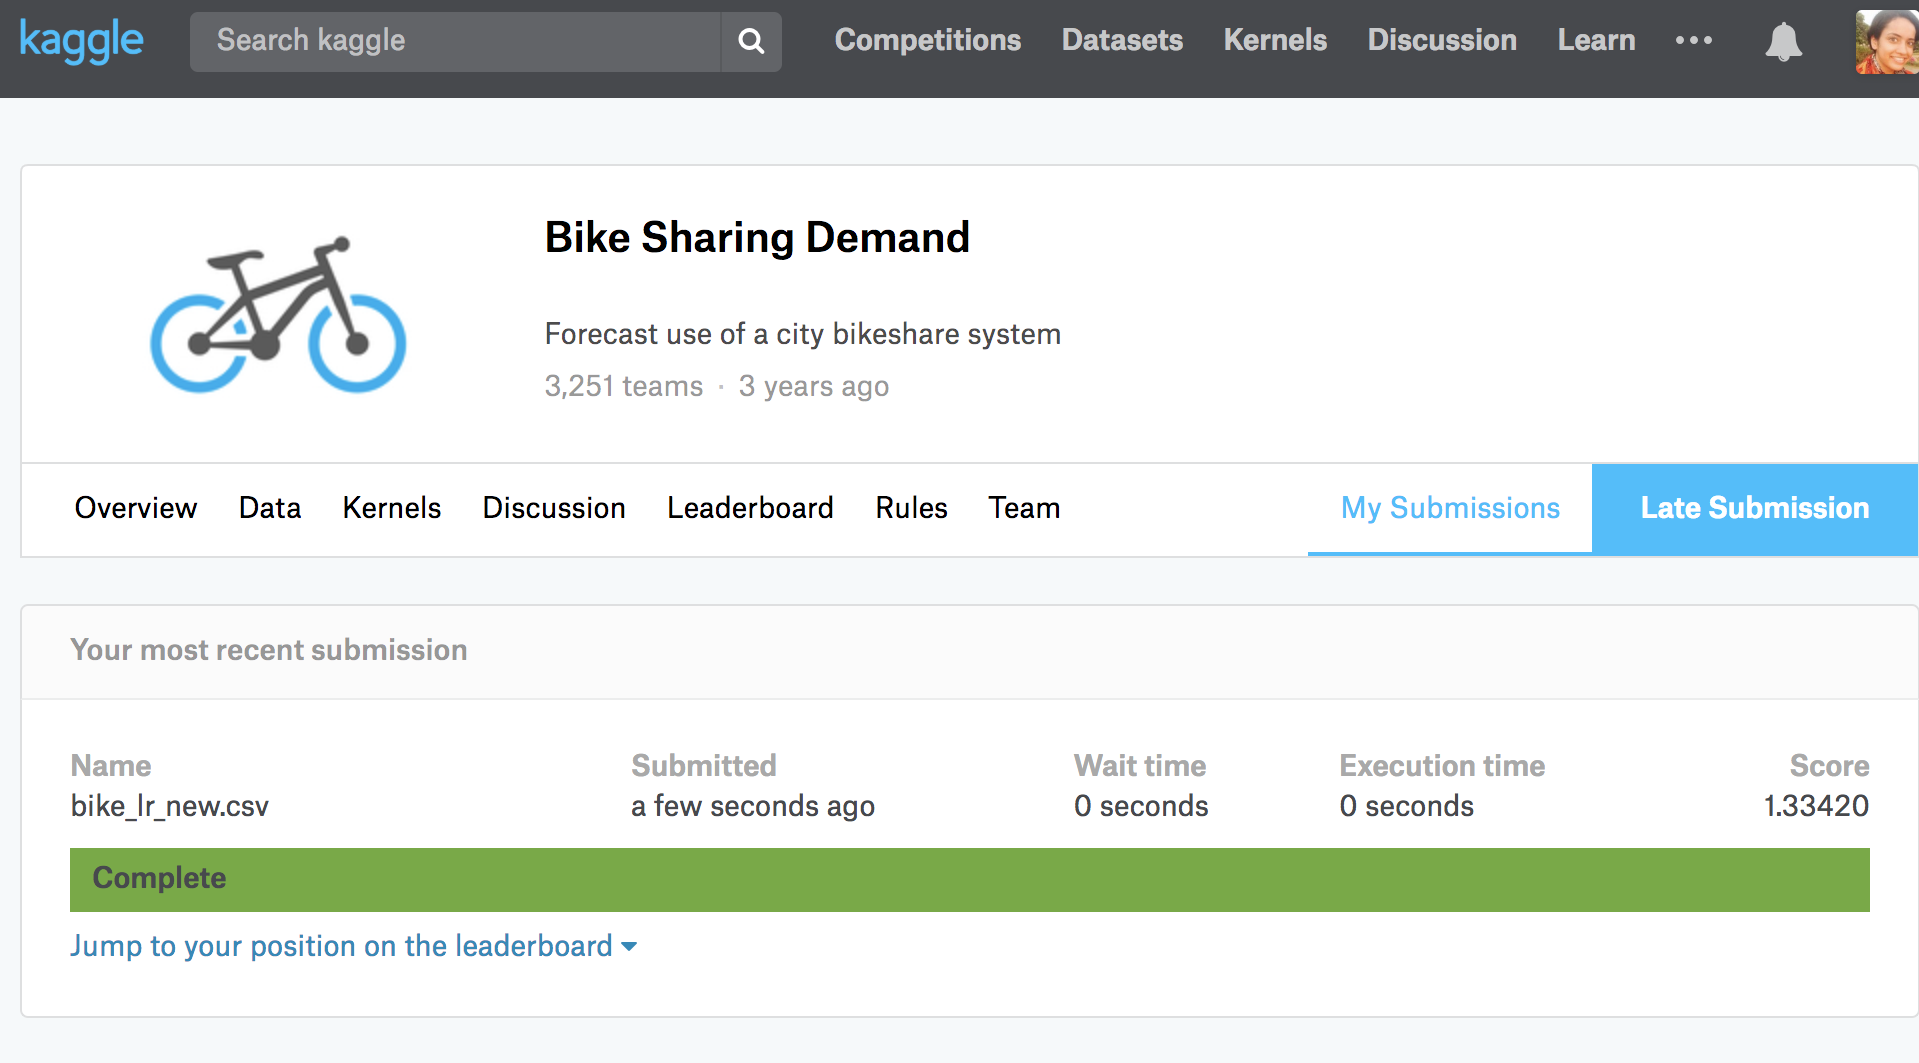

For k = 12, the above kaggle result is shown

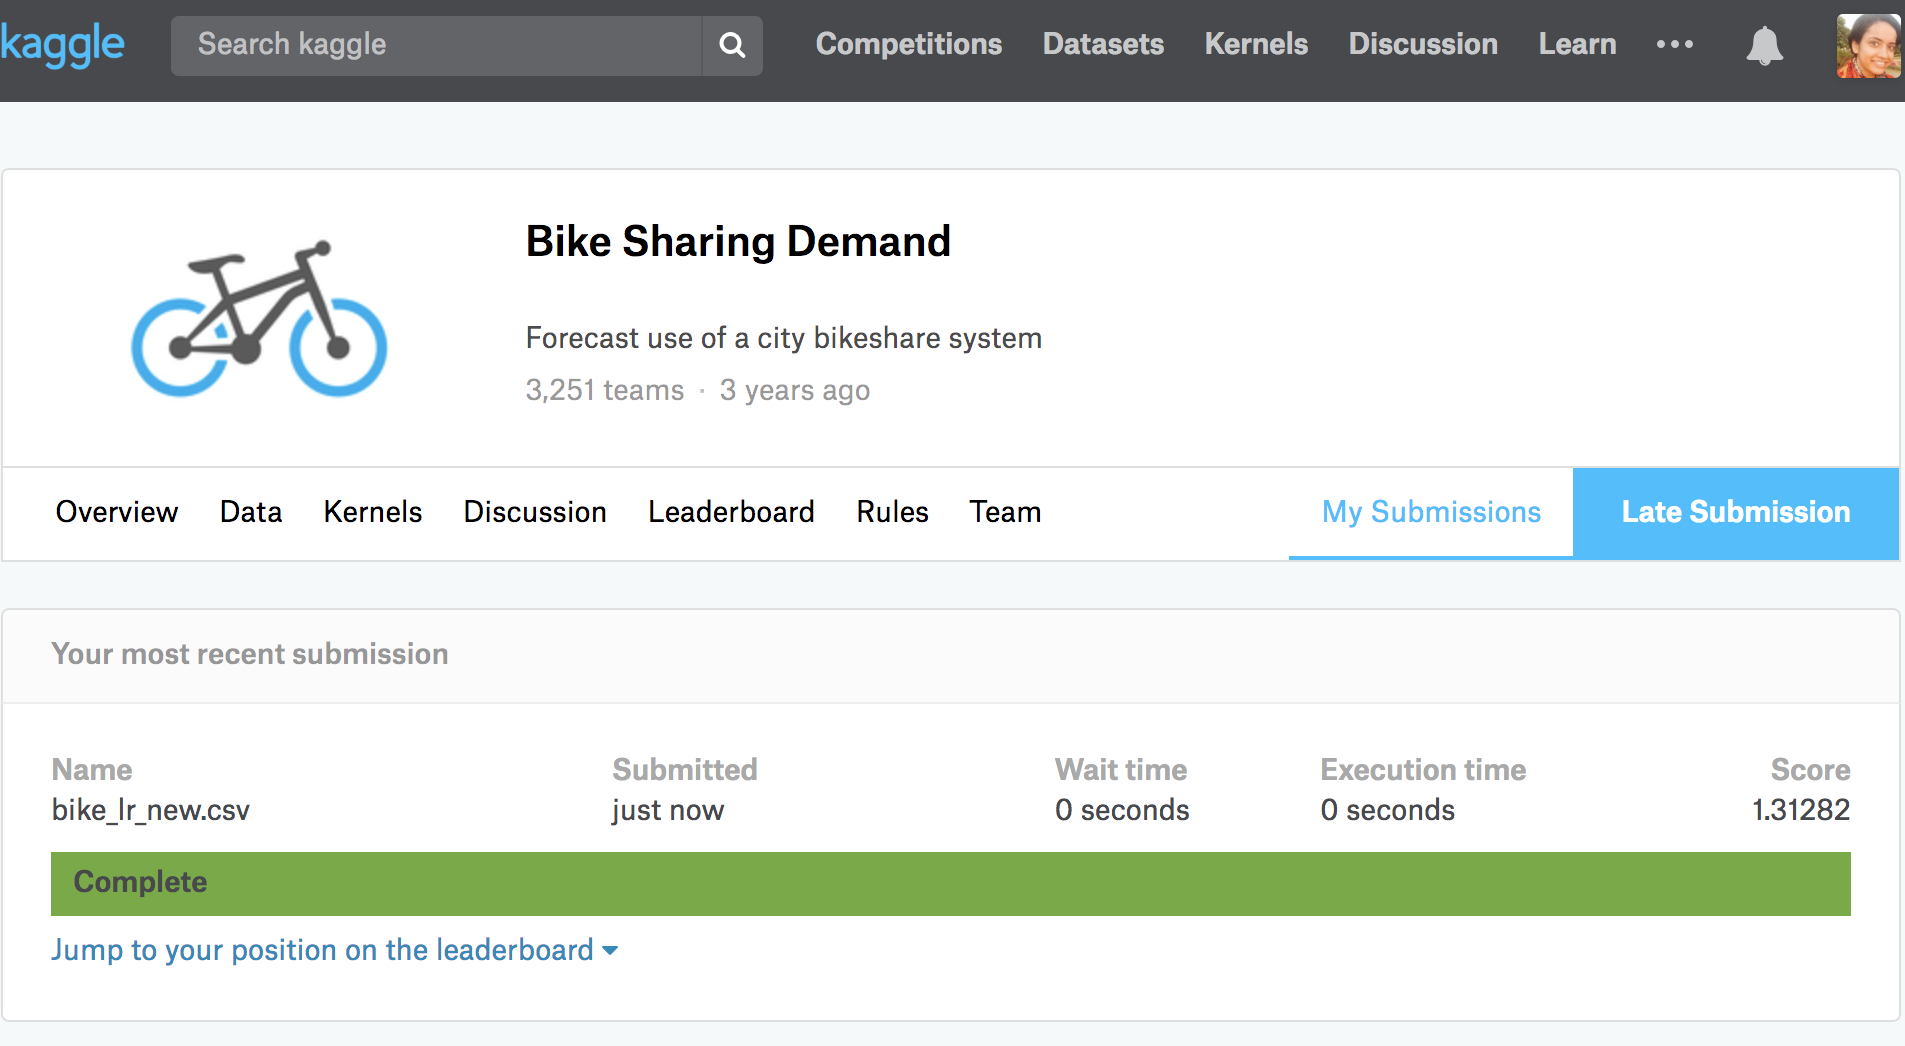

For k = 7,  the above Kaggle result is shown

### Discussion of the model

* The models with different best features can be seen above. I chose k=7 as I saw the RMSE scores were lower or equal which indicates that it performs well.
* k = 12 probably better explains the model.

# Core task: bike demand extension 1 (2 separate LR models)

Building on what you learned in your solution to the previous section, build separate linear regression models for the other two target variables (instead of the `count` target variable):  

`
registered: number of registered user
casual:     number of non-registered user
`

Specifically, you should do the following:

* Derive additional features.
  * OHE features such as  season
  * Can you think of any other features to derive from this data? [optional]
* Do feature selection using `SelectKBest`. 
  * See a full section on Feature Selection in Lab04 Notebook for details on how to do this. 
* Put all modeling steps (including Feature Selection) in a Pipeline 
  * __NOTE: Perform any OHE steps outside of the pipeline for this homework.__
* Present your experimental results in tabular form (pandas dataframe).
  * Describe the linear regression model, number of input features used, MAE, RMSE and MAPE, feature familires used (e.g., Baseline features, Season OHE, etc.).
* Discuss your best result (in terms of process followed, features used and any other interesting discoveries that you came across). Were the selected features here the same as what you selected in your solution to Section 6? 


In [651]:
X_reg, y_reg = train.iloc[:, 1:], train['registered']
X_reg = train.drop(['datetime','registered', 'casual', 'count'], axis=1)
X_reg.head()

,holiday,workingday,temp,atemp,humidity,windspeed,weather1,weather2,weather3,weather4,season1,season2,season3,season4,hour,day,month,year
0,0,0,9.84,14.395,81,0.0,1,0,0,0,1,0,0,0,0,5,1,0
1,0,0,9.02,13.635,80,0.0,1,0,0,0,1,0,0,0,1,5,1,0
2,0,0,9.02,13.635,80,0.0,1,0,0,0,1,0,0,0,2,5,1,0
3,0,0,9.84,14.395,75,0.0,1,0,0,0,1,0,0,0,3,5,1,0
4,0,0,9.84,14.395,75,0.0,1,0,0,0,1,0,0,0,4,5,1,0


In [652]:
X_cas, y_cas = train.iloc[:, 1:], train['casual']
X_cas = train.drop(['datetime','registered', 'casual', 'count'], axis=1)
X_cas.head()

,holiday,workingday,temp,atemp,humidity,windspeed,weather1,weather2,weather3,weather4,season1,season2,season3,season4,hour,day,month,year
0,0,0,9.84,14.395,81,0.0,1,0,0,0,1,0,0,0,0,5,1,0
1,0,0,9.02,13.635,80,0.0,1,0,0,0,1,0,0,0,1,5,1,0
2,0,0,9.02,13.635,80,0.0,1,0,0,0,1,0,0,0,2,5,1,0
3,0,0,9.84,14.395,75,0.0,1,0,0,0,1,0,0,0,3,5,1,0
4,0,0,9.84,14.395,75,0.0,1,0,0,0,1,0,0,0,4,5,1,0


In [653]:
X_reg.shape

(10886, 18)

In [654]:
X_cas.shape

(10886, 18)

### RE-run Machine Learning with Target variable as "Registered"

In [700]:
from sklearn.model_selection import  train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg, test_size=.3, random_state=0)

Since, season and weather are having OHE features, we can go ahead with feature selection.

#### Feature Selection

In [701]:
df = pd.DataFrame(X_train).copy()
df["label"] = y_train

per_feat = select_kbest_reg(df, 'label', k=14)
per_feat_sorted = per_feat.sort_values(["F Score", "P Value"], ascending=[False, False])
top_k_feature_indices = per_feat_sorted['Attribute'].values.flatten()
print("\n Feature Score for a linear regression using correlation\n")
print(per_feat_sorted)   

print(np.linalg.norm(y_train))


 Feature Score for a linear regression using correlation

        F Score        P Value  Support   Attribute
14  1296.800472  2.169452e-262     True        hour
2    843.176752  6.452129e-176     True        temp
3    813.639983  3.994344e-170     True       atemp
4    570.319498  1.294545e-121     True    humidity
17   543.091555  4.283623e-116     True        year
10   333.847849   4.983973e-73     True     season1
16   237.504136   8.574231e-53     True       month
1    115.906246   7.768005e-27     True  workingday
8     90.353034   2.614341e-21     True    weather3
12    71.494595   3.299795e-17     True     season3
15    71.362797   3.525552e-17     True         day
6     62.484946   3.062185e-15     True    weather1
5     61.252272   5.697823e-15     True   windspeed
13    32.086972   1.527911e-08     True     season4
11    14.470577   1.434795e-04    False     season2
7      7.411146   6.496849e-03    False    weather2
0      2.416684   1.200904e-01    False     holiday
9    

* First, I selected 12 features but some of the OHE variables were getting excluded, so I updated it to select 15 best features.
* Next, I checked the F score, which was significantly lower for the features 11, 7, 0, 9. So, I chose k = 14.
* We go forward with the following 15 features: 
    
    ```F Score        P Value  Support   Attribute
14  1296.800472  2.169452e-262     True        hour
2    843.176752  6.452129e-176     True        temp
3    813.639983  3.994344e-170     True       atemp
4    570.319498  1.294545e-121     True    humidity
17   543.091555  4.283623e-116     True        year
10   333.847849   4.983973e-73     True     season1
16   237.504136   8.574231e-53     True       month
1    115.906246   7.768005e-27     True  workingday
8     90.353034   2.614341e-21     True    weather3
12    71.494595   3.299795e-17     True     season3
15    71.362797   3.525552e-17     True         day
6     62.484946   3.062185e-15     True    weather1
5     61.252272   5.697823e-15     True   windspeed
13    32.086972   1.527911e-08     True     season4
```

In [702]:
feature_importances = per_feat[["F Score", "Attribute"]] #Order of appearence in dataframe
feature_importances_sorted = per_feat_sorted[["F Score", "Attribute"]] #Order of appearence in dataframe
feature_importances

,F Score,Attribute
0,2.416684,holiday
1,115.906246,workingday
2,843.176752,temp
3,813.639983,atemp
4,570.319498,humidity
5,61.252272,windspeed
6,62.484946,weather1
7,7.411146,weather2
8,90.353034,weather3
9,0.000480,weather4


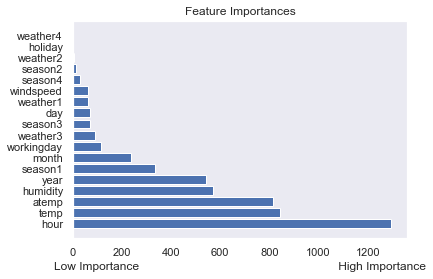

In [703]:
# Plot the feature importances of the Linear Regression
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.figure() 
plt.title("Feature importances")
sortedNames = np.array(feature_importances_sorted)[:, 1]
sortedImportances = np.array(feature_importances_sorted)[:, 0]

plt.title('Feature Importances')
plt.barh(range(len(sortedNames)), sortedImportances, color='b', align='center')
plt.yticks(range(len(sortedNames)), sortedNames)
plt.xlabel('Low Importance                                                           High Importance')
plt.grid()
plt.show()

In [704]:
#A closer look at TopFeatureSelector
k=15
featureScores = feature_importances[["F Score"]].values.flatten()
tf = TopFeatureSelector(featureScores, k)
tf.fit(X_train)
print(tf.feature_indices_)
#X_train[:,tf.feature_indices_]
X_train.values[:,tf.feature_indices_]
#X_train.info
#type(X)

[ 1  2  3  4  5  6  8 10 11 12 13 14 15 16 17]


array([[ 1.   , 32.8  , 37.12 , ...,  2.   ,  8.   ,  1.   ],
       [ 1.   , 32.8  , 35.605, ...,  3.   ,  8.   ,  1.   ],
       [ 1.   ,  4.92 ,  6.82 , ...,  0.   ,  2.   ,  1.   ],
       ...,
       [ 0.   , 27.06 , 31.06 , ...,  6.   , 10.   ,  1.   ],
       [ 0.   , 14.76 , 17.425, ...,  6.   , 12.   ,  1.   ],
       [ 0.   , 33.62 , 35.605, ...,  5.   ,  7.   ,  0.   ]])

In [705]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
featureScores = feature_importances[["F Score"]].values.flatten()
k=15
preparation_and_feature_selection_pipeline = Pipeline([
    #('preparation', ......stand),
    ("std_scaler", StandardScaler()),
    ('feature_selection', TopFeatureSelector(featureScores, k)) 
]) 
    
top_k_features = preparation_and_feature_selection_pipeline.fit_transform(X_train.values)

In [662]:
top_k_features[0:3] #looking at the first 3 features

array([[ 0.68343061,  1.62612244,  1.60195841, -0.51430022, -0.21471814,
         0.71107756, -0.28996593, -0.57674413, -0.57795641,  1.72781818,
        -0.57593594,  0.20987572, -0.50431263,  0.43365212,  1.00341791],
       [ 0.68343061,  1.62612244,  1.42280637, -1.34479894, -1.55027889,
         0.71107756, -0.28996593, -0.57674413, -0.57795641,  1.72781818,
        -0.57593594,  0.93071455, -0.0056282 ,  0.43365212,  1.00341791],
       [ 0.68343061, -1.9600452 , -1.98108231, -0.61811256,  0.02766743,
         0.71107756, -0.28996593,  1.73387115, -0.57795641, -0.5787646 ,
        -0.57593594, -0.36679534, -1.50168149, -1.30597893,  1.00341791]])

#### Feature Engineering and Model building

In [706]:
#Above steps is to double-check. Now, FS+prediction starts
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
#('preparation', ......stand),
#SKLearn's linear regression pipeline
k=15
featureScores = feature_importances[["F Score"]].values.flatten()
preparation_and_feature_selection_pipeline = Pipeline([
        ("std_scaler", StandardScaler()),
        ('feature_selection', TopFeatureSelector(featureScores, k)),
        ('lineReg', LinearRegression())
    ])
#print(preparation_and_feature_selection_pipeline)
preparation_and_feature_selection_pipeline.fit(X_train.values, y_train) 

Pipeline(memory=None,
     steps=[('std_scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('feature_selection', TopFeatureSelector(feature_importances=array([2.41668e+00, 1.15906e+02, 8.43177e+02, 8.13640e+02, 5.70319e+02,
       6.12523e+01, 6.24849e+01, 7.41115e+00, 9.03530e+01, 4.80395e-04,
       3.33848...  k=15)), ('lineReg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

#### Metric Calculation

In [668]:
#Calculate stuff for metrics
y_train_pred = preparation_and_feature_selection_pipeline.predict(X_train)
train_time = time.time()-start

start = time.time()
y_test_pred = preparation_and_feature_selection_pipeline.predict(X_test)
test_time = time.time()-start

#Root_Mean_Square_Log_Error(RMSE) is accuracy criteria for this problem
# errors on  count
print('RMSE train: %.3f' % np.sqrt(mean_squared_error(y_train+1, y_train_pred+1)))
print('RMSE test: %.3f' % np.sqrt(mean_squared_error(y_test + 1, y_test_pred)))
print('R2 train: %.3f' % r2_score(y_train+1, y_train_pred))
print('R2 test: %.3f' % r2_score(y_test+1, y_test_pred))
print("MAE train: %.3f" % mean_absolute_error(y_train+1, y_train_pred))
print("MAE test: %.3f" % mean_absolute_error(y_test, y_test_pred))
print("MAPE train: %.3f" % mean_absolute_percentage_error(y_train, y_train_pred))
print("MAPE test: %.3f" % mean_absolute_percentage_error(y_test, y_test_pred))   

RMSE train: 123.045
RMSE test: 122.004
R2 train: 0.342
R2 test: 0.334
MAE train: 88.861
MAE test: 89.074
MAPE train: inf
MAPE test: inf


/anaconda3/envs/i526/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


In [670]:
expLog.loc[len(expLog)] = ["SKLearn KBest LR (Registered)",
                           np.round(np.sqrt(mean_squared_error(y_train, y_train_pred)),3),
                           np.round(r2_score(y_train, y_train_pred), 3),
                           np.round(mean_absolute_error(y_train, y_train_pred), 3),
                           np.round(mean_absolute_percentage_error(y_train, y_train_pred),3),    
                           train_time,
                           np.round(np.sqrt(mean_squared_error(y_test, y_test_pred)),3),
                           np.round(r2_score(y_test+1, y_test_pred), 3),                       
                           np.round(mean_absolute_error(y_test, y_test_pred), 3),
                           np.round(mean_absolute_percentage_error(y_test, y_test_pred),3),
                           test_time]
expLog

/anaconda3/envs/i526/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


,Model description,RMSE train,R2 Train,MAE train,MAPE train,Train Time,RMSE test,R2 test,MAE test,MAPE test,Test Time
0,SKLearn Linear Regression vanilla,140.858,0.398,105.685,339.812000,0.002435,140.211,0.395,105.622,355.454000,0.000162
1,SKLearn Decision Tree,0.276,1.000,0.007,0.047000,0.037741,62.105,0.881,36.238,37.833000,0.000919
2,SKLearn Random Forest,14.955,0.993,9.161,11.024000,4.524797,42.532,0.944,26.043,31.302000,0.206483
3,SKLearn KBest LR,140.872,0.398,105.573,339.399000,323.992354,297.788,-1.952,245.430,381.917000,0.001200
4,"SKLearn KBest LR, k=7",141.953,0.388,106.298,336.122000,119.289571,237.734,-0.893,190.769,290.431000,0.001422
5,"SKLearn KBest LR, k=7",123.045,0.342,89.069,inf,9.615397,121.995,0.334,89.074,inf,0.001272
6,SKLearn KBest LR (Registered),123.045,0.342,89.069,inf,9.615397,121.995,0.334,89.074,inf,0.001272


RMSE train: 140.917
RMSE test: 132.233
R2 train: 0.397
R2 test: 0.418


,Model description,RMSE train,Train Time,RMSE test,R2 test,Test Time,MAPE Train,MAPE Test
0,SKLearn Linear Regression with Feature Eng,140.872,25.893815,132.284,0.001692,0.417,339.399,246.312
1,SKLearn Linear Regression (Registered),140.917,2056.560356,132.202,0.001180,0.418,339.515,245.876


#### Let's fit using the entire training data

In [707]:
preparation_and_feature_selection_pipeline.fit(X,train['registered']) 

Pipeline(memory=None,
     steps=[('std_scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('feature_selection', TopFeatureSelector(feature_importances=array([2.41668e+00, 1.15906e+02, 8.43177e+02, 8.13640e+02, 5.70319e+02,
       6.12523e+01, 6.24849e+01, 7.41115e+00, 9.03530e+01, 4.80395e-04,
       3.33848...  k=15)), ('lineReg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [708]:
test_1=pd.read_csv('./Kaggle-Bike-Sharing-Demand-Challenge/test.csv')
test_1.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [709]:
### Dont forget to Generate features and 


# Create a new column called df.weather1 where the value is 1
# if df.weather is 1 and 0 if not
test_1['weather1'] = np.where(test_1['weather']==1, 1, 0)  #ifelse assignment
test_1['weather2'] = np.where(test_1['weather']==2, 1, 0)
test_1['weather3'] = np.where(test_1['weather']==3, 1, 0)
test_1['weather4'] = np.where(test_1['weather']==4, 1, 0)

# dont forget to drop the original feature
test_1.drop(['weather'], axis=1, inplace=True)

test_1['season1'] = np.where(test_1['season']==1, 1, 0)  #ifelse assignment
test_1['season2'] = np.where(test_1['season']==2, 1, 0)
test_1['season3'] = np.where(test_1['season']==3, 1, 0)
test_1['season4'] = np.where(test_1['season']==4, 1, 0)
test_1.drop(['season'], axis=1, inplace=True)


test_1["hour"] = [t.hour for t in pd.DatetimeIndex(test_1.datetime)]
test_1["day"] = [t.dayofweek for t in pd.DatetimeIndex(test_1.datetime)]
test_1["month"] = [t.month for t in pd.DatetimeIndex(test_1.datetime)]
test_1['year'] = [t.year for t in pd.DatetimeIndex(test_1.datetime)]
test_1['year'] = test_1['year'].map({2011:0, 2012:1})


X_test1=test_1.iloc[:,1:]

X_test1.head(10)

,holiday,workingday,temp,atemp,humidity,windspeed,weather1,weather2,weather3,weather4,season1,season2,season3,season4,hour,day,month,year
0,0,1,10.66,11.365,56,26.0027,1,0,0,0,1,0,0,0,0,3,1,0
1,0,1,10.66,13.635,56,0.0000,1,0,0,0,1,0,0,0,1,3,1,0
2,0,1,10.66,13.635,56,0.0000,1,0,0,0,1,0,0,0,2,3,1,0
3,0,1,10.66,12.880,56,11.0014,1,0,0,0,1,0,0,0,3,3,1,0
4,0,1,10.66,12.880,56,11.0014,1,0,0,0,1,0,0,0,4,3,1,0
5,0,1,9.84,11.365,60,15.0013,1,0,0,0,1,0,0,0,5,3,1,0
6,0,1,9.02,10.605,60,15.0013,1,0,0,0,1,0,0,0,6,3,1,0
7,0,1,9.02,10.605,55,15.0013,1,0,0,0,1,0,0,0,7,3,1,0
8,0,1,9.02,10.605,55,19.0012,1,0,0,0,1,0,0,0,8,3,1,0
9,0,1,9.84,11.365,52,15.0013,0,1,0,0,1,0,0,0,9,3,1,0


#### Let's predict

In [710]:
# let's try the full pipeline on a few testing instances
#X_test = scl.transform(X_test)

pred_regist = preparation_and_feature_selection_pipeline.predict(X_test1)

print("Predictions:", pred_regist)

Predictions: [-13.72995232 -16.83927885 -10.32360537 ... 280.28573679 292.05141026
 287.56708374]


In [711]:
df_reg = X_test1

df_reg['registered'] = np.round(pred_regist)

In [712]:
df_reg.head()

,holiday,workingday,temp,atemp,humidity,windspeed,weather1,weather2,weather3,weather4,season1,season2,season3,season4,hour,day,month,year,registered
0,0,1,10.66,11.365,56,26.0027,1,0,0,0,1,0,0,0,0,3,1,0,-14.0
1,0,1,10.66,13.635,56,0.0000,1,0,0,0,1,0,0,0,1,3,1,0,-17.0
2,0,1,10.66,13.635,56,0.0000,1,0,0,0,1,0,0,0,2,3,1,0,-10.0
3,0,1,10.66,12.880,56,11.0014,1,0,0,0,1,0,0,0,3,3,1,0,1.0
4,0,1,10.66,12.880,56,11.0014,1,0,0,0,1,0,0,0,4,3,1,0,7.0


In [713]:
df_reg = df_reg.drop(['season1', 'season2', 'season3','season4', 'holiday', 'workingday','temp', 'atemp', 'humidity', 
                            'windspeed', 'hour', 'day', 'month', 'year', 'weather1', 'weather2',
                            'weather3', 'weather4'], axis=1)

df_reg.head()

,registered
0,-14.0
1,-17.0
2,-10.0
3,1.0
4,7.0


#### Clip all negative results

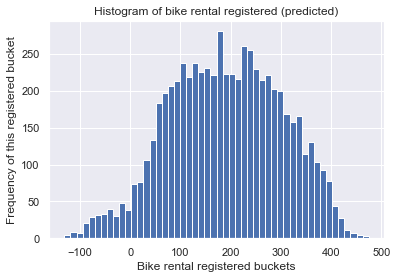

In [364]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import math

# the histogram of the data
n, bins, patches = plt.hist(df_reg['registered'], 50)

plt.xlabel('Bike rental registered buckets')
plt.ylabel('Frequency of this registered bucket')
plt.title(r'Histogram of bike rental registered (predicted)')
plt.grid(True)

plt.show()

In [365]:
df_reg['registered'] = np.where(df_reg['registered'] < 0, 0, df_reg['registered'])

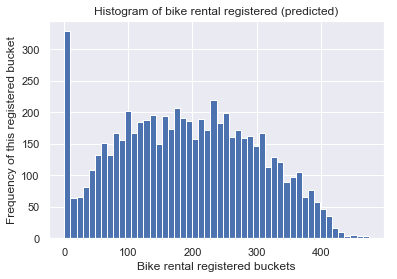

In [368]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import math

# the histogram of the data
n, bins, patches = plt.hist(df_reg['registered'], 50)

plt.xlabel('Bike rental registered buckets')
plt.ylabel('Frequency of this registered bucket')
plt.title(r'Histogram of bike rental registered (predicted)')
plt.grid(True)

plt.show()

#### Let's discuss the model 

### Machine Learning with Target variable as "Casual"

In [714]:
from sklearn.model_selection import  train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_cas, y_cas, test_size=.3, random_state=0)

In [715]:
X_train.shape

(7620, 18)

Since, season and weather are having OHE features, we can go ahead with feature selection.

#### Feature Selection

In [716]:
df = pd.DataFrame(X_train).copy()
df["label"] = y_train

per_feat = select_kbest_reg(df, 'label', k=14)
per_feat_sorted = per_feat.sort_values(["F Score", "P Value"], ascending=[False, False])
top_k_feature_indices = per_feat_sorted['Attribute'].values.flatten()
print("\n Feature Score for a linear regression using correlation\n")
print(per_feat_sorted)   

print(np.linalg.norm(y_train))


 Feature Score for a linear regression using correlation

        F Score        P Value  Support   Attribute
2   2185.595067   0.000000e+00     True        temp
3   2120.362611   0.000000e+00     True       atemp
4   1014.044057  5.023065e-209     True    humidity
1    841.617133  1.303198e-175     True  workingday
14   780.018610  1.656453e-163     True        hour
10   471.600445  1.641715e-101     True     season1
15   451.598301   2.086401e-97     True         day
12   283.707495   1.566993e-62     True     season3
11   149.212608   5.351810e-34     True     season2
17   146.506982   2.035539e-33     True        year
6     90.701218   2.197026e-21     True    weather1
8     78.348896   1.060236e-18     True    weather3
16    69.897154   7.360533e-17     True       month
5     64.076278   1.374261e-15     True   windspeed
13    58.339405   2.474424e-14    False     season4
7     23.297184   1.415049e-06    False    weather2
0     16.606019   4.647193e-05    False     holiday
9    

* We do not need weather 2 and 4 as they fall under Misty to Foggy to Rains and Ice
* Further, holiday has a low F statistic, so we can ignore it.

In [717]:
feature_importances = per_feat[["F Score", "Attribute"]] #Order of appearence in dataframe
feature_importances_sorted = per_feat_sorted[["F Score", "Attribute"]] #Order of appearence in dataframe
feature_importances

,F Score,Attribute
0,16.606019,holiday
1,841.617133,workingday
2,2185.595067,temp
3,2120.362611,atemp
4,1014.044057,humidity
5,64.076278,windspeed
6,90.701218,weather1
7,23.297184,weather2
8,78.348896,weather3
9,0.355766,weather4


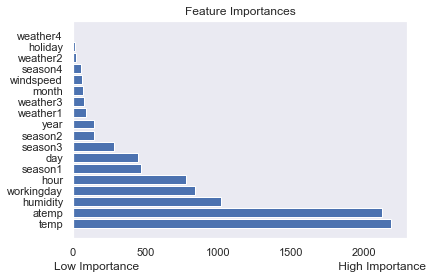

In [718]:
# Plot the feature importances of the forest
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.figure() 
plt.title("Feature importances")
sortedNames = np.array(feature_importances_sorted)[:, 1]
sortedImportances = np.array(feature_importances_sorted)[:, 0]

plt.title('Feature Importances')
plt.barh(range(len(sortedNames)), sortedImportances, color='b', align='center')
plt.yticks(range(len(sortedNames)), sortedNames)
plt.xlabel('Low Importance                                                           High Importance')
plt.grid()
plt.show()

In [684]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
featureScores = feature_importances[["F Score"]].values.flatten()
k=15
preparation_and_feature_selection_pipeline = Pipeline([
    #('preparation', ......stand),
    ("std_scaler", StandardScaler()),
    ('feature_selection', TopFeatureSelector(featureScores, k)) 
]) 
    
top_k_features = preparation_and_feature_selection_pipeline.fit_transform(X_train.values)

In [719]:
top_k_features[0:3] #looking at the first 3 features

array([[ 0.68343061,  1.62612244,  1.60195841, -0.51430022, -0.21471814,
         0.71107756, -0.28996593, -0.57674413, -0.57795641,  1.72781818,
        -0.57593594,  0.20987572, -0.50431263,  0.43365212,  1.00341791],
       [ 0.68343061,  1.62612244,  1.42280637, -1.34479894, -1.55027889,
         0.71107756, -0.28996593, -0.57674413, -0.57795641,  1.72781818,
        -0.57593594,  0.93071455, -0.0056282 ,  0.43365212,  1.00341791],
       [ 0.68343061, -1.9600452 , -1.98108231, -0.61811256,  0.02766743,
         0.71107756, -0.28996593,  1.73387115, -0.57795641, -0.5787646 ,
        -0.57593594, -0.36679534, -1.50168149, -1.30597893,  1.00341791]])

In [720]:
#A closer look at TopFeatureSelector
k=14
featureScores = feature_importances[["F Score"]].values.flatten()
tf = TopFeatureSelector(featureScores, k)
tf.fit(X_train)
print(tf.feature_indices_)
#X_train[:,tf.feature_indices_]
X_train.values[:,tf.feature_indices_]
#X_train.info
#type(X)

[ 1  2  3  4  5  6  8 10 11 12 14 15 16 17]


array([[ 1.   , 32.8  , 37.12 , ...,  2.   ,  8.   ,  1.   ],
       [ 1.   , 32.8  , 35.605, ...,  3.   ,  8.   ,  1.   ],
       [ 1.   ,  4.92 ,  6.82 , ...,  0.   ,  2.   ,  1.   ],
       ...,
       [ 0.   , 27.06 , 31.06 , ...,  6.   , 10.   ,  1.   ],
       [ 0.   , 14.76 , 17.425, ...,  6.   , 12.   ,  1.   ],
       [ 0.   , 33.62 , 35.605, ...,  5.   ,  7.   ,  0.   ]])

#### Feature Engineering and Model building

In [721]:
#Above steps is to double-check. Now, FS+prediction starts
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
#('preparation', ......stand),
#SKLearn's linear regression pipeline
k=14
featureScores = feature_importances[["F Score"]].values.flatten()
preparation_and_feature_selection_pipeline = Pipeline([
        ("std_scaler", StandardScaler()),
        ('feature_selection', TopFeatureSelector(featureScores, k)),
        ('lineReg', LinearRegression())
    ])
#print(preparation_and_feature_selection_pipeline)
preparation_and_feature_selection_pipeline.fit(X_train.values, y_train) 

Pipeline(memory=None,
     steps=[('std_scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('feature_selection', TopFeatureSelector(feature_importances=array([1.66060e+01, 8.41617e+02, 2.18560e+03, 2.12036e+03, 1.01404e+03,
       6.40763e+01, 9.07012e+01, 2.32972e+01, 7.83489e+01, 3.55766e-01,
       4.71600...  k=14)), ('lineReg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

#### Metric Calculation

In [689]:
#Calculate stuff for metrics
y_train_pred = preparation_and_feature_selection_pipeline.predict(X_train)
train_time = time.time()-start

start = time.time()
y_test_pred = preparation_and_feature_selection_pipeline.predict(X_test)
test_time = time.time()-start

#Root_Mean_Square_Log_Error(RMSE) is accuracy criteria for this problem
# errors on  count
print('RMSE train: %.3f' % np.sqrt(mean_squared_error(y_train+1, y_train_pred+1)))
print('RMSE test: %.3f' % np.sqrt(mean_squared_error(y_test + 1, y_test_pred)))
print('R2 train: %.3f' % r2_score(y_train+1, y_train_pred))
print('R2 test: %.3f' % r2_score(y_test+1, y_test_pred))
print("MAE train: %.3f" % mean_absolute_error(y_train+1, y_train_pred))
print("MAE test: %.3f" % mean_absolute_error(y_test, y_test_pred))
print("MAPE train: %.3f" % mean_absolute_percentage_error(y_train, y_train_pred))
print("MAPE test: %.3f" % mean_absolute_percentage_error(y_test, y_test_pred))   

RMSE train: 35.981
RMSE test: 36.347
R2 train: 0.476
R2 test: 0.481
MAE train: 24.314
MAE test: 24.491
MAPE train: inf
MAPE test: inf


/anaconda3/envs/i526/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


In [690]:
expLog.loc[len(expLog)] = ["SKLearn KBest LR (Casual)",
                           np.round(np.sqrt(mean_squared_error(y_train, y_train_pred)),3),
                           np.round(r2_score(y_train, y_train_pred), 3),
                           np.round(mean_absolute_error(y_train, y_train_pred), 3),
                           np.round(mean_absolute_percentage_error(y_train, y_train_pred),3),    
                           train_time,
                           np.round(np.sqrt(mean_squared_error(y_test, y_test_pred)),3),
                           np.round(r2_score(y_test+1, y_test_pred), 3),                       
                           np.round(mean_absolute_error(y_test, y_test_pred), 3),
                           np.round(mean_absolute_percentage_error(y_test, y_test_pred),3),
                           test_time]
expLog

/anaconda3/envs/i526/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


,Model description,RMSE train,R2 Train,MAE train,MAPE train,Train Time,RMSE test,R2 test,MAE test,MAPE test,Test Time
0,SKLearn Linear Regression vanilla,140.858,0.398,105.685,339.812000,0.002435,140.211,0.395,105.622,355.454000,0.000162
1,SKLearn Decision Tree,0.276,1.000,0.007,0.047000,0.037741,62.105,0.881,36.238,37.833000,0.000919
2,SKLearn Random Forest,14.955,0.993,9.161,11.024000,4.524797,42.532,0.944,26.043,31.302000,0.206483
3,SKLearn KBest LR,140.872,0.398,105.573,339.399000,323.992354,297.788,-1.952,245.430,381.917000,0.001200
4,"SKLearn KBest LR, k=7",141.953,0.388,106.298,336.122000,119.289571,237.734,-0.893,190.769,290.431000,0.001422
5,"SKLearn KBest LR, k=7",123.045,0.342,89.069,inf,9.615397,121.995,0.334,89.074,inf,0.001272
6,SKLearn KBest LR (Registered),123.045,0.342,89.069,inf,9.615397,121.995,0.334,89.074,inf,0.001272
7,SKLearn KBest LR (Casual),35.981,0.477,24.410,inf,27.386402,36.332,0.481,24.491,inf,0.000968


Please ignore row 5, it is invalid.

#### Let's fit using the entire training data

In [722]:
preparation_and_feature_selection_pipeline.fit(X,train['casual']) 

Pipeline(memory=None,
     steps=[('std_scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('feature_selection', TopFeatureSelector(feature_importances=array([1.66060e+01, 8.41617e+02, 2.18560e+03, 2.12036e+03, 1.01404e+03,
       6.40763e+01, 9.07012e+01, 2.32972e+01, 7.83489e+01, 3.55766e-01,
       4.71600...  k=14)), ('lineReg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

#### Let's predict

In [728]:
test_1=pd.read_csv('./Kaggle-Bike-Sharing-Demand-Challenge/test.csv')
test_1.head()

### Dont forget to Generate features and 


# Create a new column called df.weather1 where the value is 1
# if df.weather is 1 and 0 if not
test_1['weather1'] = np.where(test_1['weather']==1, 1, 0)  #ifelse assignment
test_1['weather2'] = np.where(test_1['weather']==2, 1, 0)
test_1['weather3'] = np.where(test_1['weather']==3, 1, 0)
test_1['weather4'] = np.where(test_1['weather']==4, 1, 0)

# dont forget to drop the original feature
test_1.drop(['weather'], axis=1, inplace=True)

test_1['season1'] = np.where(test_1['season']==1, 1, 0)  #ifelse assignment
test_1['season2'] = np.where(test_1['season']==2, 1, 0)
test_1['season3'] = np.where(test_1['season']==3, 1, 0)
test_1['season4'] = np.where(test_1['season']==4, 1, 0)
test_1.drop(['season'], axis=1, inplace=True)


test_1["hour"] = [t.hour for t in pd.DatetimeIndex(test_1.datetime)]
test_1["day"] = [t.dayofweek for t in pd.DatetimeIndex(test_1.datetime)]
test_1["month"] = [t.month for t in pd.DatetimeIndex(test_1.datetime)]
test_1['year'] = [t.year for t in pd.DatetimeIndex(test_1.datetime)]
test_1['year'] = test_1['year'].map({2011:0, 2012:1})


X_test1=test_1.iloc[:,1:]

X_test1.head(10)

,holiday,workingday,temp,atemp,humidity,windspeed,weather1,weather2,weather3,weather4,season1,season2,season3,season4,hour,day,month,year
0,0,1,10.66,11.365,56,26.0027,1,0,0,0,1,0,0,0,0,3,1,0
1,0,1,10.66,13.635,56,0.0000,1,0,0,0,1,0,0,0,1,3,1,0
2,0,1,10.66,13.635,56,0.0000,1,0,0,0,1,0,0,0,2,3,1,0
3,0,1,10.66,12.880,56,11.0014,1,0,0,0,1,0,0,0,3,3,1,0
4,0,1,10.66,12.880,56,11.0014,1,0,0,0,1,0,0,0,4,3,1,0
5,0,1,9.84,11.365,60,15.0013,1,0,0,0,1,0,0,0,5,3,1,0
6,0,1,9.02,10.605,60,15.0013,1,0,0,0,1,0,0,0,6,3,1,0
7,0,1,9.02,10.605,55,15.0013,1,0,0,0,1,0,0,0,7,3,1,0
8,0,1,9.02,10.605,55,19.0012,1,0,0,0,1,0,0,0,8,3,1,0
9,0,1,9.84,11.365,52,15.0013,0,1,0,0,1,0,0,0,9,3,1,0


In [729]:
# let's try the full pipeline on a few testing instances
#X_test = scl.transform(X_test)

pred_casual = preparation_and_feature_selection_pipeline.predict(X_test1)

print("Predictions:", pred_casual)

Predictions: [-21.36624123 -18.30578223 -17.17618904 ...  12.02502783  16.66776581
  11.2492681 ]


In [730]:
df_cas = X_test1

df_cas['casual'] = np.round(pred_casual)

In [731]:
df_cas.head()

,holiday,workingday,temp,atemp,humidity,windspeed,weather1,weather2,weather3,weather4,season1,season2,season3,season4,hour,day,month,year,casual
0,0,1,10.66,11.365,56,26.0027,1,0,0,0,1,0,0,0,0,3,1,0,-21.0
1,0,1,10.66,13.635,56,0.0000,1,0,0,0,1,0,0,0,1,3,1,0,-18.0
2,0,1,10.66,13.635,56,0.0000,1,0,0,0,1,0,0,0,2,3,1,0,-17.0
3,0,1,10.66,12.880,56,11.0014,1,0,0,0,1,0,0,0,3,3,1,0,-17.0
4,0,1,10.66,12.880,56,11.0014,1,0,0,0,1,0,0,0,4,3,1,0,-16.0


In [732]:
df_cas = df_cas.drop(['season1', 'season2', 'season3','season4', 'holiday', 'workingday','temp', 'atemp', 'humidity', 
                            'windspeed', 'hour', 'day', 'month', 'year', 'weather1', 'weather2',
                            'weather3', 'weather4'], axis=1)

df_cas.head()

,casual
0,-21.0
1,-18.0
2,-17.0
3,-17.0
4,-16.0


#### Clip all negative results

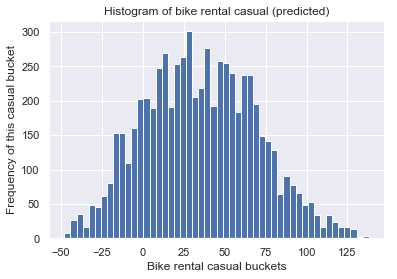

In [733]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import math

# the histogram of the data
n, bins, patches = plt.hist(df_cas['casual'], 50)

plt.xlabel('Bike rental casual buckets')
plt.ylabel('Frequency of this casual bucket')
plt.title(r'Histogram of bike rental casual (predicted)')
plt.grid(True)

plt.show()

In [734]:
df_cas['casual'] = np.where(df_cas['casual'] < 0, 0, df_cas['casual'])

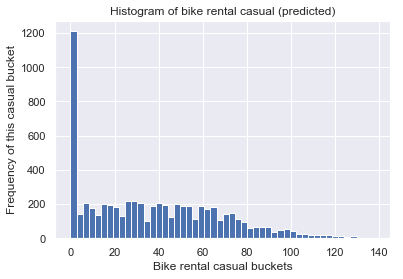

In [735]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import math

# the histogram of the data
n, bins, patches = plt.hist(df_cas['casual'], 50)

plt.xlabel('Bike rental casual buckets')
plt.ylabel('Frequency of this casual bucket')
plt.title(r'Histogram of bike rental casual (predicted)')
plt.grid(True)

plt.show()

#### Let's discuss the model

The model predicts with 14 best features with the scores mentioned in the table above.

# Core task: bike demand extension 2 (target = log(demand+1))

The distribution of the raw `count` feature is very skewed with most values occuring to the left of the count domain. To make this distribution less skewed (and more normal distributed, it is common to take the log of the value + 1 (to avoid log(0)). 

For this task:
* calculate the log transformed target `np.log(count+1)`
* do regression as usual
* Do NOT forget to take the inverse of the log transformation to return your targets to the original count scale.  `np.exp(pred - 1)` 

Overall, we want you to build a linear regression model (based on the `count` target) that builds on what you learned in your solutions to the previous section. 

Specifically, you should do the following:
* Derive additional features.
  * OHE features such as  season, 
  * If barplot demand over each hour of the the day, you will notice interesting patterns. E.g., you might be able to  segregate the bike demand in three hourly categories, like the following:

         `High       : 7-9 and 17-19 hours
         Average    : 10-16 hours
         Low        : 0-6 and 20-24 hours`
         
* Perform feature selection using __`Sequential Backward Selection`__ algorithm.
  * See Lab05 Notebook for a full section on Sequential Backward Selection includig sample code.
* Put all modeling steps in a Pipeline.
  * __NOTE: Perform any OHE steps outside of the pipeline for this homework.__
  * Feature Selection can be performed prior to the pipeline or as part of the pipeline. Please discuss what you choose and why.
* Present your experimental results in tabular form (using a pandas dataframe). 
  * Describe the linear regression model including number of input features used and types of processing used (e.g., OHE, feature selection).  
  * Report MAE, RMSE and MAPE and run time in your table for each experiment. 
* Do a Kaggle submission with your best linear regression model
* Screenshot your kaggle submission results and paste the screenshot into your notebook submission.
  * Create a markdown cell, paste in the screenshot image and run the cell to convert the link to a graphic.
* Discuss your best result (in terms of process followed, features used and any other interesting discoveries that you came across). 

### Transform the target variable

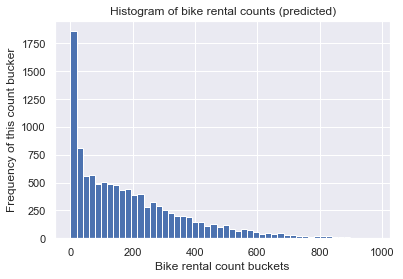

In [738]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import math

# the histogram of the data
n, bins, patches = plt.hist(train['count'], 50)

plt.xlabel('Bike rental count buckets')
plt.ylabel('Frequency of this count bucker')
plt.title(r'Histogram of bike rental counts (predicted)')
plt.grid(True)

plt.show()

* We can see that the data is left-skewed

In [739]:
train['count'] = np.log(train['count']+1)

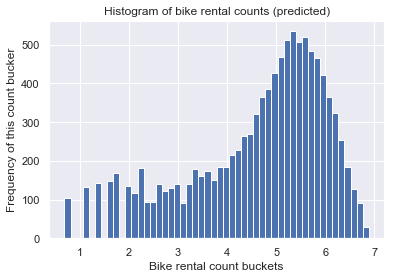

In [740]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import math

# the histogram of the data
n, bins, patches = plt.hist(train['count'], 50)

plt.xlabel('Bike rental count buckets')
plt.ylabel('Frequency of this count bucker')
plt.title(r'Histogram of bike rental counts (predicted)')
plt.grid(True)

plt.show()

* Now, the data looks well distributed

### Separate the input variables and target variable

In [741]:
X, y = train.iloc[:, 1:], train['count']
X = train.drop(['datetime','registered', 'casual', 'count'], axis=1)

In [742]:
X.shape

(10886, 18)

In [744]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [745]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [746]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        #split training data into train and validation subsets
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []
            # look at all combinations of dim-1 features 
            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]
        ## TODO  please complete!
        # using crossfold validation select the single best model from among all selected subsets
        # using cross-validated performance utility
        
        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

In [747]:
from sklearn.linear_model import SGDRegressor
SGDRegressor(penalty='l1')

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=None, n_iter=None, penalty='l1',
       power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False)

In [753]:
#from sklearn.metrics import neg_mean_squared_error
from sklearn.metrics import explained_variance_score

#neg_mean_squared_error
lr = SGDRegressor(penalty='l1', alpha=.5)

# selecting features
sbs = SBS(lr, k_features=1, scoring=explained_variance_score)
sbs.fit(X_train_std, y_train)

/anaconda3/envs/i526/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [557]:
# model_pip = Pipeline("scale",StandardScaler(),
#                     "sbs", SBS(lr, k_features=1, scoring=explained_variance_score))

In [754]:
list(zip( np.arange(0, len(sbs.scores_)), k_feat, np.round(sbs.scores_, 3), sbs.subsets_)  )

[(0,
  18,
  0.213,
  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17)),
 (1, 17, 0.211, (0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17)),
 (2, 16, 0.218, (0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17)),
 (3, 15, 0.219, (1, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17)),
 (4, 14, 0.219, (1, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16)),
 (5, 13, 0.212, (1, 3, 4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16)),
 (6, 12, 0.211, (1, 3, 4, 5, 6, 9, 10, 12, 13, 14, 15, 16)),
 (7, 11, 0.218, (1, 3, 4, 6, 9, 10, 12, 13, 14, 15, 16)),
 (8, 10, 0.217, (1, 3, 4, 9, 10, 12, 13, 14, 15, 16)),
 (9, 9, 0.209, (1, 3, 4, 9, 10, 12, 13, 14, 16)),
 (10, 8, 0.205, (1, 3, 4, 9, 10, 12, 14, 16)),
 (11, 7, 0.216, (1, 3, 4, 10, 12, 14, 16)),
 (12, 6, 0.219, (1, 3, 4, 10, 14, 16)),
 (13, 5, 0.21, (1, 4, 10, 14, 16)),
 (14, 4, 0.21, (1, 4, 14, 16)),
 (15, 3, 0.199, (1, 4, 14)),
 (16, 2, 0.201, (4, 14)),
 (17, 1, 0.201, (14,))]

* As we can see in the following list, the performance of the linear regression model improved on the validation dataset as we increased the number of features.
* The subset of the 6 featues doing best.

### Getting the best subset

In [759]:
best_subset = list(sbs.subsets_[12])
best_subset

[1, 3, 4, 10, 14, 16]

### Fiting without best subset

In [760]:
lr.fit(X_train_std, y_train)
print('Training accuracy:', lr.score(X_train_std, y_train))
print('Test accuracy:', lr.score(X_test_std, y_test))

Training accuracy: 0.17523029444609228
Test accuracy: 0.17305573716936862


/anaconda3/envs/i526/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


### Fiting with the best subset

In [761]:
lr.fit(X_train_std[:, best_subset], y_train)
print('Training accuracy:', lr.score(X_train_std[:, best_subset], y_train))
print('Test accuracy:', lr.score(X_test_std[:, best_subset], y_test))

Training accuracy: 0.20755295019528497
Test accuracy: 0.20565794535161275


/anaconda3/envs/i526/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


### Metric calculation

In [762]:
#Calculate stuff for metrics
y_train_pred_int = lr.predict(X_train_std[:, best_subset])
train_time = time.time()-start

start = time.time()
y_test_pred_int = lr.predict(X_test_std[:, best_subset])
test_time = time.time()-start

In [763]:
y_train_pred = np.exp(y_train_pred_int) - 1
y_train_pred

array([ 71.31231098, 119.58540305, 114.10797699, ..., 119.58540305,
        78.35802979,  78.35802979])

In [764]:
y_test_pred = np.exp(y_test_pred_int) - 1
y_test_pred 

array([ 94.57584563,  74.75330045, 131.33458975, ..., 108.87935547,
        71.31231098, 103.8882369 ])

In [765]:

#Root_Mean_Square_Log_Error(RMSE) is accuracy criteria for this problem
# errors on  count
print('RMSE train: %.3f' % np.sqrt(mean_squared_error(y_train+1, y_train_pred+1)))
print('RMSE test: %.3f' % np.sqrt(mean_squared_error(y_test + 1, y_test_pred)))
print('R2 train: %.3f' % r2_score(y_train+1, y_train_pred))
print('R2 test: %.3f' % r2_score(y_test+1, y_test_pred))
print("MAE train: %.3f" % mean_absolute_error(y_train+1, y_train_pred))
print("MAE test: %.3f" % mean_absolute_error(y_test, y_test_pred))
print("MAPE train: %.3f" % mean_absolute_percentage_error(y_train, y_train_pred))
print("MAPE test: %.3f" % mean_absolute_percentage_error(y_test, y_test_pred))   

RMSE train: 102.747
RMSE test: 101.572
R2 train: -5170.901
R2 test: -5010.796
MAE train: 96.596
MAE test: 97.418
MAPE train: 2343.399
MAPE test: 2358.299


In [766]:
expLog.loc[len(expLog)] = ["SKLearn SBS Count log",
                           np.round(np.sqrt(mean_squared_error(y_train, y_train_pred)),3),
                           np.round(r2_score(y_train, y_train_pred), 3),
                           np.round(mean_absolute_error(y_train, y_train_pred), 3),
                           np.round(mean_absolute_percentage_error(y_train, y_train_pred),3),    
                           train_time,
                           np.round(np.sqrt(mean_squared_error(y_test, y_test_pred)),3),
                           np.round(r2_score(y_test+1, y_test_pred), 3),                       
                           np.round(mean_absolute_error(y_test, y_test_pred), 3),
                           np.round(mean_absolute_percentage_error(y_test, y_test_pred),3),
                           test_time]
expLog

,Model description,RMSE train,R2 Train,MAE train,MAPE train,Train Time,RMSE test,R2 test,MAE test,MAPE test,Test Time
0,SKLearn Linear Regression vanilla,140.858,0.398,105.685,339.812000,0.002435,140.211,0.395,105.622,355.454000,0.000162
1,SKLearn Decision Tree,0.276,1.000,0.007,0.047000,0.037741,62.105,0.881,36.238,37.833000,0.000919
2,SKLearn Random Forest,14.955,0.993,9.161,11.024000,4.524797,42.532,0.944,26.043,31.302000,0.206483
3,SKLearn KBest LR,140.872,0.398,105.573,339.399000,323.992354,297.788,-1.952,245.430,381.917000,0.001200
4,"SKLearn KBest LR, k=7",141.953,0.388,106.298,336.122000,119.289571,237.734,-0.893,190.769,290.431000,0.001422
5,"SKLearn KBest LR, k=7",123.045,0.342,89.069,inf,9.615397,121.995,0.334,89.074,inf,0.001272
6,SKLearn KBest LR (Registered),123.045,0.342,89.069,inf,9.615397,121.995,0.334,89.074,inf,0.001272
7,SKLearn KBest LR (Casual),35.981,0.477,24.410,inf,27.386402,36.332,0.481,24.491,inf,0.000968
8,SKLearn SBS Count log,102.747,-5267.819,97.596,2343.399000,1479.635973,102.521,-5010.796,97.418,2358.299000,0.000382


I have kept R^2 for my understanding.

### Let's fit using the entire training dataset

In [767]:
X.head()

,holiday,workingday,temp,atemp,humidity,windspeed,weather1,weather2,weather3,weather4,season1,season2,season3,season4,hour,day,month,year
0,0,0,9.84,14.395,81,0.0,1,0,0,0,1,0,0,0,0,5,1,0
1,0,0,9.02,13.635,80,0.0,1,0,0,0,1,0,0,0,1,5,1,0
2,0,0,9.02,13.635,80,0.0,1,0,0,0,1,0,0,0,2,5,1,0
3,0,0,9.84,14.395,75,0.0,1,0,0,0,1,0,0,0,3,5,1,0
4,0,0,9.84,14.395,75,0.0,1,0,0,0,1,0,0,0,4,5,1,0


In [771]:
#bestX_feat = X.drop(['weather3','season2'], axis = 1)
X_standard = sc.fit_transform(X)
X_standard=X_standard[:, best_subset]

In [770]:
lr.fit(X_standard,y) #X_train_std[:, best_subset]

/anaconda3/envs/i526/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDRegressor(alpha=0.5, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=None, n_iter=None, penalty='l1',
       power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False)

### Let's predict!

In [778]:
test_1=pd.read_csv('./Kaggle-Bike-Sharing-Demand-Challenge/test.csv')
test_1.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [779]:
### Dont forget to Generate features and 


# Create a new column called df.weather1 where the value is 1
# if df.weather is 1 and 0 if not
test_1['weather1'] = np.where(test_1['weather']==1, 1, 0)  #ifelse assignment
test_1['weather2'] = np.where(test_1['weather']==2, 1, 0)
test_1['weather3'] = np.where(test_1['weather']==3, 1, 0)
test_1['weather4'] = np.where(test_1['weather']==4, 1, 0)

# dont forget to drop the original feature
test_1.drop(['weather'], axis=1, inplace=True)

test_1['season1'] = np.where(test_1['season']==1, 1, 0)  #ifelse assignment
test_1['season2'] = np.where(test_1['season']==2, 1, 0)
test_1['season3'] = np.where(test_1['season']==3, 1, 0)
test_1['season4'] = np.where(test_1['season']==4, 1, 0)
test_1.drop(['season'], axis=1, inplace=True)


test_1["hour"] = [t.hour for t in pd.DatetimeIndex(test_1.datetime)]
test_1["day"] = [t.dayofweek for t in pd.DatetimeIndex(test_1.datetime)]
test_1["month"] = [t.month for t in pd.DatetimeIndex(test_1.datetime)]
test_1['year'] = [t.year for t in pd.DatetimeIndex(test_1.datetime)]
test_1['year'] = test_1['year'].map({2011:0, 2012:1})


X_test1=test_1.iloc[:,1:]

X_test1.head(10)

,holiday,workingday,temp,atemp,humidity,windspeed,weather1,weather2,weather3,weather4,season1,season2,season3,season4,hour,day,month,year
0,0,1,10.66,11.365,56,26.0027,1,0,0,0,1,0,0,0,0,3,1,0
1,0,1,10.66,13.635,56,0.0000,1,0,0,0,1,0,0,0,1,3,1,0
2,0,1,10.66,13.635,56,0.0000,1,0,0,0,1,0,0,0,2,3,1,0
3,0,1,10.66,12.880,56,11.0014,1,0,0,0,1,0,0,0,3,3,1,0
4,0,1,10.66,12.880,56,11.0014,1,0,0,0,1,0,0,0,4,3,1,0
5,0,1,9.84,11.365,60,15.0013,1,0,0,0,1,0,0,0,5,3,1,0
6,0,1,9.02,10.605,60,15.0013,1,0,0,0,1,0,0,0,6,3,1,0
7,0,1,9.02,10.605,55,15.0013,1,0,0,0,1,0,0,0,7,3,1,0
8,0,1,9.02,10.605,55,19.0012,1,0,0,0,1,0,0,0,8,3,1,0
9,0,1,9.84,11.365,52,15.0013,0,1,0,0,1,0,0,0,9,3,1,0


In [780]:
X_test1_standard = sc.transform(X_test1)

In [781]:
X_test1_standard = X_test1_standard[:, best_subset]
y_f_pred = lr.predict(X_test1_standard)
print("Predictions:", y_f_pred)

Predictions: [4.03320555 4.0803755  4.12754545 ... 5.02377447 5.07094442 5.11811437]


In [782]:
y_f_pred_in_log = np.exp(y_f_pred) - 1
print("Predictions:", y_f_pred_in_log)

Predictions: [ 55.4415478   58.1676831   61.02549114 ... 150.98388173 158.3247262
 166.02013457]


In [792]:
df_submit_log = test

df_submit_log['count'] = np.round(y_f_pred_in_log)

In [793]:
df_submit_log.head(10)

,datetime,holiday,workingday,temp,atemp,humidity,windspeed,weather1,weather2,weather3,weather4,season1,season2,season3,season4,hour,day,month,year,count
0,2011-01-20 00:00:00,0,1,10.66,11.365,56,26.0027,1,0,0,0,1,0,0,0,0,3,1,0,55.0
1,2011-01-20 01:00:00,0,1,10.66,13.635,56,0.0000,1,0,0,0,1,0,0,0,1,3,1,0,58.0
2,2011-01-20 02:00:00,0,1,10.66,13.635,56,0.0000,1,0,0,0,1,0,0,0,2,3,1,0,61.0
3,2011-01-20 03:00:00,0,1,10.66,12.880,56,11.0014,1,0,0,0,1,0,0,0,3,3,1,0,64.0
4,2011-01-20 04:00:00,0,1,10.66,12.880,56,11.0014,1,0,0,0,1,0,0,0,4,3,1,0,67.0
5,2011-01-20 05:00:00,0,1,9.84,11.365,60,15.0013,1,0,0,0,1,0,0,0,5,3,1,0,70.0
6,2011-01-20 06:00:00,0,1,9.02,10.605,60,15.0013,1,0,0,0,1,0,0,0,6,3,1,0,74.0
7,2011-01-20 07:00:00,0,1,9.02,10.605,55,15.0013,1,0,0,0,1,0,0,0,7,3,1,0,78.0
8,2011-01-20 08:00:00,0,1,9.02,10.605,55,19.0012,1,0,0,0,1,0,0,0,8,3,1,0,81.0
9,2011-01-20 09:00:00,0,1,9.84,11.365,52,15.0013,0,1,0,0,1,0,0,0,9,3,1,0,85.0


In [794]:
df_submit_log = df_submit_log.drop(['season1', 'season2', 'season3','season4', 'holiday', 'workingday','temp', 'atemp', 
                                    'humidity', 'windspeed', 'hour', 'day', 'month', 'year', 'weather1', 'weather2', 'weather3',
                                    'weather4'], axis=1)

df_submit_log.head()

,datetime,count
0,2011-01-20 00:00:00,55.0
1,2011-01-20 01:00:00,58.0
2,2011-01-20 02:00:00,61.0
3,2011-01-20 03:00:00,64.0
4,2011-01-20 04:00:00,67.0


In [788]:
df_submit_log.shape

(6493, 1)

### Check if negative values exist

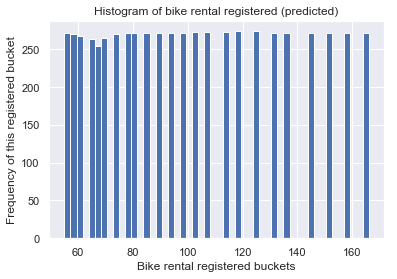

In [787]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import math

# the histogram of the data
n, bins, patches = plt.hist(df_submit_log['count'], 50)

plt.xlabel('Bike rental count buckets')
plt.ylabel('Frequency of this count bucket')
plt.title(r'Histogram of bike rental count (predicted)')
plt.grid(True)

plt.show()

In [795]:
df_submit_log.to_csv('bike_log_lr_new.csv', index=False)

### Kaggle Result

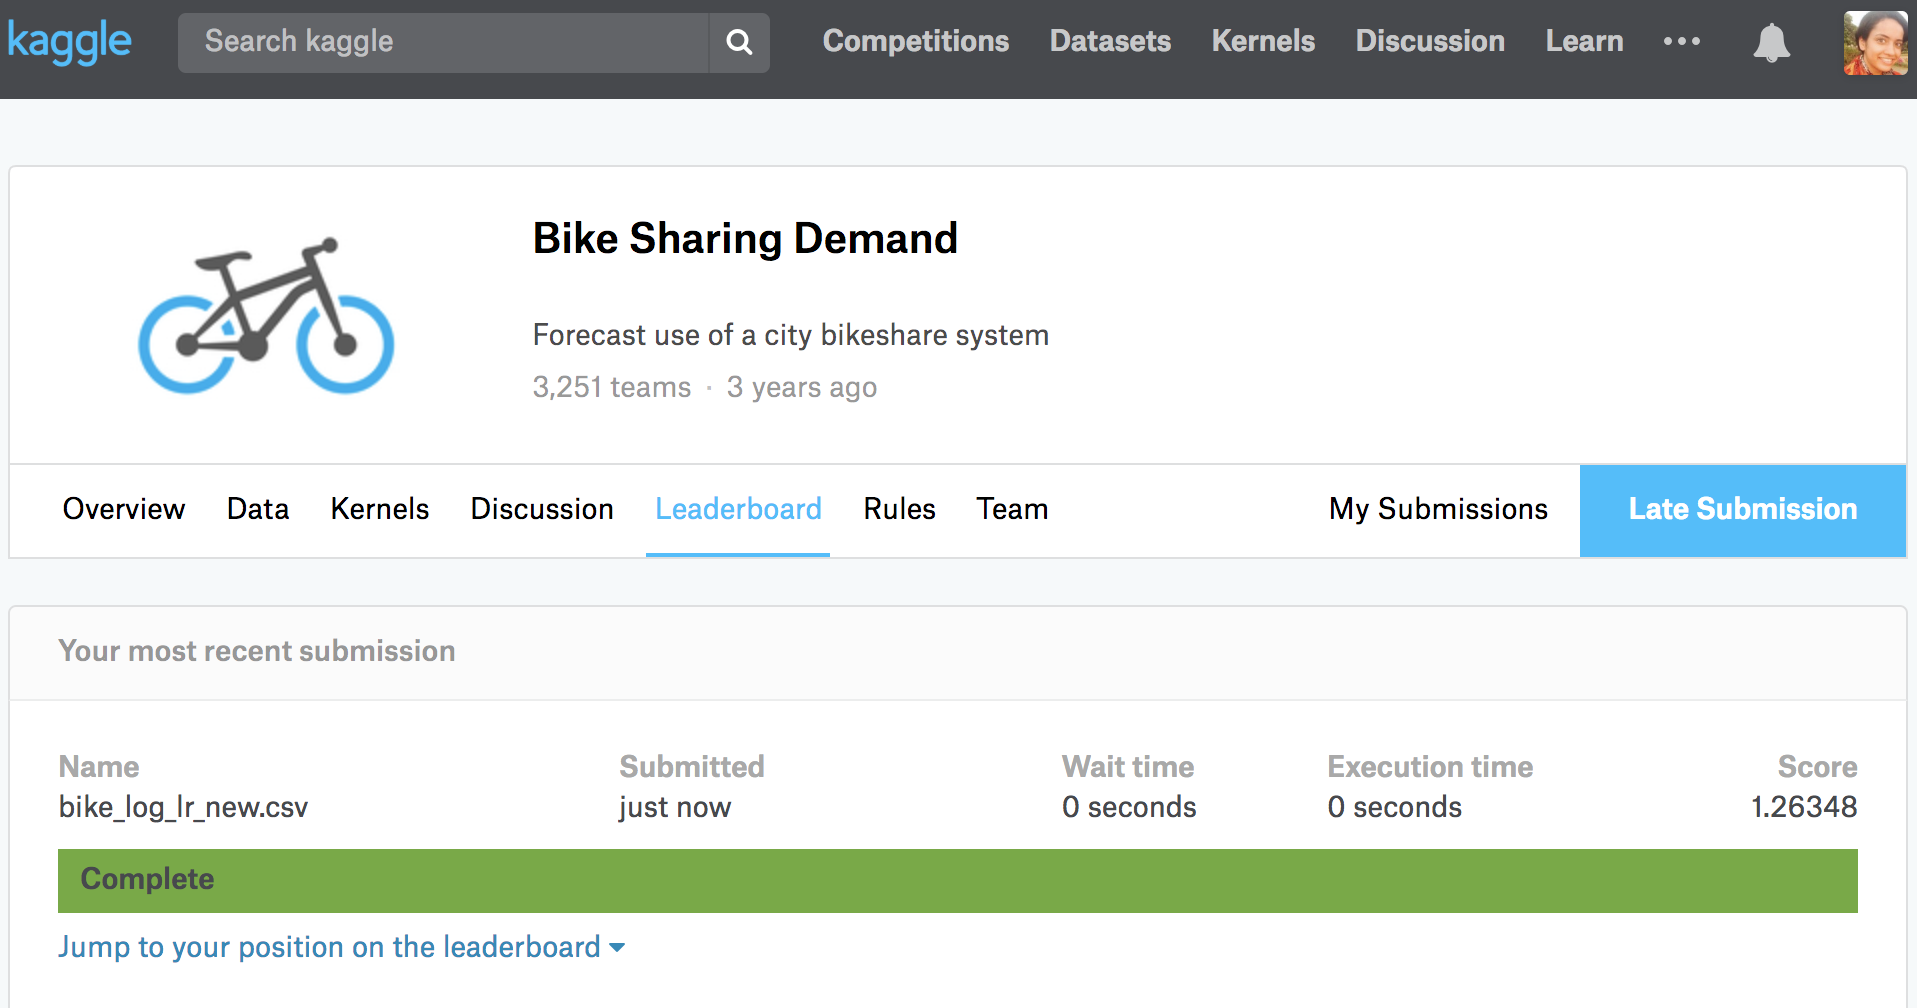

Seems like the score is not as good as the Kbest.
I followed a simple process of selecting the features based on the SBS. Then fit the model with the best subset. Calculated the metrics and then fit the model on entire training data set. I predicted the 

#  Core task: bike demand extension 3 (LR +  Regularization)

## L1 and L2 regularization for Linear Regression
Regularization is a way of penalizing the model for excessive complexity, and this helps reduce the risk of  overfitting.

There are many ways of doing regularization but these two are the major ones:
* **L2-regularization:**
$$
f(\mathbf{w}, b) = \frac{1}{n}\sum_{i=1}^{n}\left[ (\mathbf{w}\cdot\mathbf{x}_i + b) - y_i\right]^2 + \lambda \sum_{j=1}^{m}w_j^2
$$
or in matrix way:
$$
f(\mathbf{w}, b) = \|\text{X}\cdot\mathbf{w} + b\cdot\mathbf{1}_n - \mathbf{y}\|_2^2 + \lambda \|\mathbf{w}\|_2^2
$$
* **L1-regularization:**
$$
f(\mathbf{w}, b) = \frac{1}{n}\sum_{i=1}^{n}\left[ (\mathbf{w}\cdot\mathbf{x}_i + b) - y_i\right]^2 + \lambda \sum_{j=1}^{m}|w_j|
$$
or in matrix way:
$$
f(\mathbf{w}, b) = \|\text{X}\cdot\mathbf{w} + b\cdot\mathbf{1}_n - \mathbf{y}\|_2^2 + \lambda \|\mathbf{w}\|_1
$$

## For this task:

Using the features and the transformed target feature, log(count+1), from the previous question (question 8), use SKLearn Ridge and LASSO linear regression classes to perform feature selection. 


* Use gridsearch to determine best value for $\alpha$ (i.e., the mixing coefficent associated with the penalty term in regularized linear regression).
* Please put all modeling steps in a Pipeline
    * NOTE please keep the OHE step separate preprocessing step for this homework
* Present your experimental results in tabular form (using a pandas dataframe). 
  * Describe the linear regression model including number of input features used and types of processing used (e.g., OHE, feature selection).  
  * Report MAE, RMSE and MAPE and run time in your table for each experiment. 
* Do a Kaggle submission with your best linear regression model
* Screenshot your kaggle submission results and paste the screenshot into your notebook submission.
  * Create a markdown cell, paste in the screenshot image and run the cell to convert the link to a graphic.
* Discuss your best result (in terms of process followed, features used and any other interesting discoveries that you came across). 

### Ridge Regression

In [804]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X_train_std[:, best_subset], y_train)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='cholesky', tol=0.001)

In [805]:
#Calculate stuff for metrics
y_train_pred_int = ridge_reg.predict(X_train_std[:, best_subset])
train_time = time.time()-start

start = time.time()
y_test_pred_int = ridge_reg.predict(X_test_std[:, best_subset])
test_time = time.time()-start

In [806]:
y_train_pred = np.exp(y_train_pred_int) - 1
y_train_pred

array([ 51.3816359 , 519.64397367, 322.73984929, ..., 181.60673003,
        87.49548434,  39.62725954])

In [807]:
y_test_pred = np.exp(y_test_pred_int) - 1
y_test_pred 

array([195.90309141,  23.17679023, 200.92685507, ..., 213.71942994,
        18.25041206, 111.57296681])

In [808]:

#Root_Mean_Square_Log_Error(RMSE) is accuracy criteria for this problem
# errors on  count
print('RMSE train: %.3f' % np.sqrt(mean_squared_error(y_train+1, y_train_pred+1)))
print('RMSE test: %.3f' % np.sqrt(mean_squared_error(y_test + 1, y_test_pred)))
print('R2 train: %.3f' % r2_score(y_train+1, y_train_pred))
print('R2 test: %.3f' % r2_score(y_test+1, y_test_pred))
print("MAE train: %.3f" % mean_absolute_error(y_train+1, y_train_pred))
print("MAE test: %.3f" % mean_absolute_error(y_test, y_test_pred))
print("MAPE train: %.3f" % mean_absolute_percentage_error(y_train, y_train_pred))
print("MAPE test: %.3f" % mean_absolute_percentage_error(y_test, y_test_pred))   

RMSE train: 193.124
RMSE test: 189.472
R2 train: -18469.971
R2 test: -17438.615
MAE train: 143.022
MAE test: 141.807
MAPE train: 2907.697
MAPE test: 2867.776


In [809]:
expLog.loc[len(expLog)] = ["SKLearn Ridge Regression (count)",
                           np.round(np.sqrt(mean_squared_error(y_train, y_train_pred)),3),
                           np.round(r2_score(y_train, y_train_pred), 3),
                           np.round(mean_absolute_error(y_train, y_train_pred), 3),
                           np.round(mean_absolute_percentage_error(y_train, y_train_pred),3),    
                           train_time,
                           np.round(np.sqrt(mean_squared_error(y_test, y_test_pred)),3),
                           np.round(r2_score(y_test+1, y_test_pred), 3),                       
                           np.round(mean_absolute_error(y_test, y_test_pred), 3),
                           np.round(mean_absolute_percentage_error(y_test, y_test_pred),3),
                           test_time]
expLog

,Model description,RMSE train,R2 Train,MAE train,MAPE train,Train Time,RMSE test,R2 test,MAE test,MAPE test,Test Time
0,SKLearn Linear Regression vanilla,140.858,0.398,105.685,339.812000,0.002435,140.211,0.395,105.622,355.454000,0.000162
1,SKLearn Decision Tree,0.276,1.000,0.007,0.047000,0.037741,62.105,0.881,36.238,37.833000,0.000919
2,SKLearn Random Forest,14.955,0.993,9.161,11.024000,4.524797,42.532,0.944,26.043,31.302000,0.206483
3,SKLearn KBest LR,140.872,0.398,105.573,339.399000,323.992354,297.788,-1.952,245.430,381.917000,0.001200
4,"SKLearn KBest LR, k=7",141.953,0.388,106.298,336.122000,119.289571,237.734,-0.893,190.769,290.431000,0.001422
5,"SKLearn KBest LR, k=7",123.045,0.342,89.069,inf,9.615397,121.995,0.334,89.074,inf,0.001272
6,SKLearn KBest LR (Registered),123.045,0.342,89.069,inf,9.615397,121.995,0.334,89.074,inf,0.001272
7,SKLearn KBest LR (Casual),35.981,0.477,24.410,inf,27.386402,36.332,0.481,24.491,inf,0.000968
8,SKLearn SBS Count log,102.747,-5267.819,97.596,2343.399000,1479.635973,102.521,-5010.796,97.418,2358.299000,0.000382
9,SKLearn Ridge Regression (count),193.124,-18613.230,144.022,2907.697000,2388.006037,190.216,-17438.615,141.807,2867.776000,0.000570


** Ignore row 5

#### Fit the model using entire data

In [812]:
X.head()

,holiday,workingday,temp,atemp,humidity,windspeed,weather1,weather2,weather3,weather4,season1,season2,season3,season4,hour,day,month,year
0,0,0,9.84,14.395,81,0.0,1,0,0,0,1,0,0,0,0,5,1,0
1,0,0,9.02,13.635,80,0.0,1,0,0,0,1,0,0,0,1,5,1,0
2,0,0,9.02,13.635,80,0.0,1,0,0,0,1,0,0,0,2,5,1,0
3,0,0,9.84,14.395,75,0.0,1,0,0,0,1,0,0,0,3,5,1,0
4,0,0,9.84,14.395,75,0.0,1,0,0,0,1,0,0,0,4,5,1,0


In [813]:
#bestX_feat = X.drop(['weather3','season2'], axis = 1)
X_standard = sc.fit_transform(X)
X_standard=X_standard[:, best_subset]

In [814]:
ridge_reg.fit(X_standard,y) #X_train_std[:, best_subset]

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='cholesky', tol=0.001)

#### Let's predict!

In [815]:
test_1=pd.read_csv('./Kaggle-Bike-Sharing-Demand-Challenge/test.csv')
test_1.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [816]:
### Dont forget to Generate features and 


# Create a new column called df.weather1 where the value is 1
# if df.weather is 1 and 0 if not
test_1['weather1'] = np.where(test_1['weather']==1, 1, 0)  #ifelse assignment
test_1['weather2'] = np.where(test_1['weather']==2, 1, 0)
test_1['weather3'] = np.where(test_1['weather']==3, 1, 0)
test_1['weather4'] = np.where(test_1['weather']==4, 1, 0)

# dont forget to drop the original feature
test_1.drop(['weather'], axis=1, inplace=True)

test_1['season1'] = np.where(test_1['season']==1, 1, 0)  #ifelse assignment
test_1['season2'] = np.where(test_1['season']==2, 1, 0)
test_1['season3'] = np.where(test_1['season']==3, 1, 0)
test_1['season4'] = np.where(test_1['season']==4, 1, 0)
test_1.drop(['season'], axis=1, inplace=True)


test_1["hour"] = [t.hour for t in pd.DatetimeIndex(test_1.datetime)]
test_1["day"] = [t.dayofweek for t in pd.DatetimeIndex(test_1.datetime)]
test_1["month"] = [t.month for t in pd.DatetimeIndex(test_1.datetime)]
test_1['year'] = [t.year for t in pd.DatetimeIndex(test_1.datetime)]
test_1['year'] = test_1['year'].map({2011:0, 2012:1})


X_test1=test_1.iloc[:,1:]

X_test1.head(10)

,holiday,workingday,temp,atemp,humidity,windspeed,weather1,weather2,weather3,weather4,season1,season2,season3,season4,hour,day,month,year
0,0,1,10.66,11.365,56,26.0027,1,0,0,0,1,0,0,0,0,3,1,0
1,0,1,10.66,13.635,56,0.0000,1,0,0,0,1,0,0,0,1,3,1,0
2,0,1,10.66,13.635,56,0.0000,1,0,0,0,1,0,0,0,2,3,1,0
3,0,1,10.66,12.880,56,11.0014,1,0,0,0,1,0,0,0,3,3,1,0
4,0,1,10.66,12.880,56,11.0014,1,0,0,0,1,0,0,0,4,3,1,0
5,0,1,9.84,11.365,60,15.0013,1,0,0,0,1,0,0,0,5,3,1,0
6,0,1,9.02,10.605,60,15.0013,1,0,0,0,1,0,0,0,6,3,1,0
7,0,1,9.02,10.605,55,15.0013,1,0,0,0,1,0,0,0,7,3,1,0
8,0,1,9.02,10.605,55,19.0012,1,0,0,0,1,0,0,0,8,3,1,0
9,0,1,9.84,11.365,52,15.0013,0,1,0,0,1,0,0,0,9,3,1,0


In [817]:
X_test1_standard = sc.transform(X_test1)

In [818]:
X_test1_standard = X_test1_standard[:, best_subset]
y_f_pred =ridge_reg.predict(X_test1_standard)
print("Predictions:", y_f_pred)

Predictions: [2.6760512  2.8697797  2.96726331 ... 5.33351044 5.52796531 5.47928824]


In [819]:
y_f_pred_in_log = np.exp(y_f_pred) - 1
print("Predictions:", y_f_pred_in_log)

Predictions: [ 13.52761322  16.63313322  18.43864909 ... 206.163935   250.63139763
 238.67605413]


In [820]:
df_submit_rr = test

df_submit_rr['count'] = np.round(y_f_pred_in_log)

In [821]:
df_submit_rr.head(10)

,datetime,holiday,workingday,temp,atemp,humidity,windspeed,weather1,weather2,weather3,weather4,season1,season2,season3,season4,hour,day,month,year,count
0,2011-01-20 00:00:00,0,1,10.66,11.365,56,26.0027,1,0,0,0,1,0,0,0,0,3,1,0,14.0
1,2011-01-20 01:00:00,0,1,10.66,13.635,56,0.0000,1,0,0,0,1,0,0,0,1,3,1,0,17.0
2,2011-01-20 02:00:00,0,1,10.66,13.635,56,0.0000,1,0,0,0,1,0,0,0,2,3,1,0,18.0
3,2011-01-20 03:00:00,0,1,10.66,12.880,56,11.0014,1,0,0,0,1,0,0,0,3,3,1,0,20.0
4,2011-01-20 04:00:00,0,1,10.66,12.880,56,11.0014,1,0,0,0,1,0,0,0,4,3,1,0,22.0
5,2011-01-20 05:00:00,0,1,9.84,11.365,60,15.0013,1,0,0,0,1,0,0,0,5,3,1,0,21.0
6,2011-01-20 06:00:00,0,1,9.02,10.605,60,15.0013,1,0,0,0,1,0,0,0,6,3,1,0,23.0
7,2011-01-20 07:00:00,0,1,9.02,10.605,55,15.0013,1,0,0,0,1,0,0,0,7,3,1,0,27.0
8,2011-01-20 08:00:00,0,1,9.02,10.605,55,19.0012,1,0,0,0,1,0,0,0,8,3,1,0,30.0
9,2011-01-20 09:00:00,0,1,9.84,11.365,52,15.0013,0,1,0,0,1,0,0,0,9,3,1,0,36.0


In [822]:
df_submit_rr = df_submit_rr.drop(['season1', 'season2', 'season3','season4', 'holiday', 'workingday','temp', 'atemp', 
                                    'humidity', 'windspeed', 'hour', 'day', 'month', 'year', 'weather1', 'weather2', 'weather3',
                                    'weather4'], axis=1)

df_submit_rr.head()

,datetime,count
0,2011-01-20 00:00:00,14.0
1,2011-01-20 01:00:00,17.0
2,2011-01-20 02:00:00,18.0
3,2011-01-20 03:00:00,20.0
4,2011-01-20 04:00:00,22.0


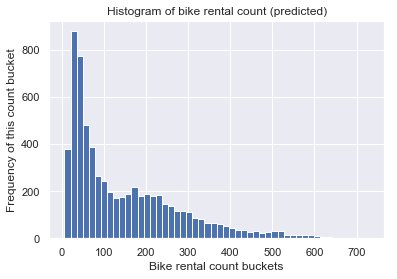

In [823]:
## check neg results
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import math

# the histogram of the data
n, bins, patches = plt.hist(df_submit_rr['count'], 50)

plt.xlabel('Bike rental count buckets')
plt.ylabel('Frequency of this count bucket')
plt.title(r'Histogram of bike rental count (predicted)')
plt.grid(True)

plt.show()

Looks good!

In [824]:
df_submit_rr.to_csv("bike_ridge.csv", index=False)

#### Kaggle submission

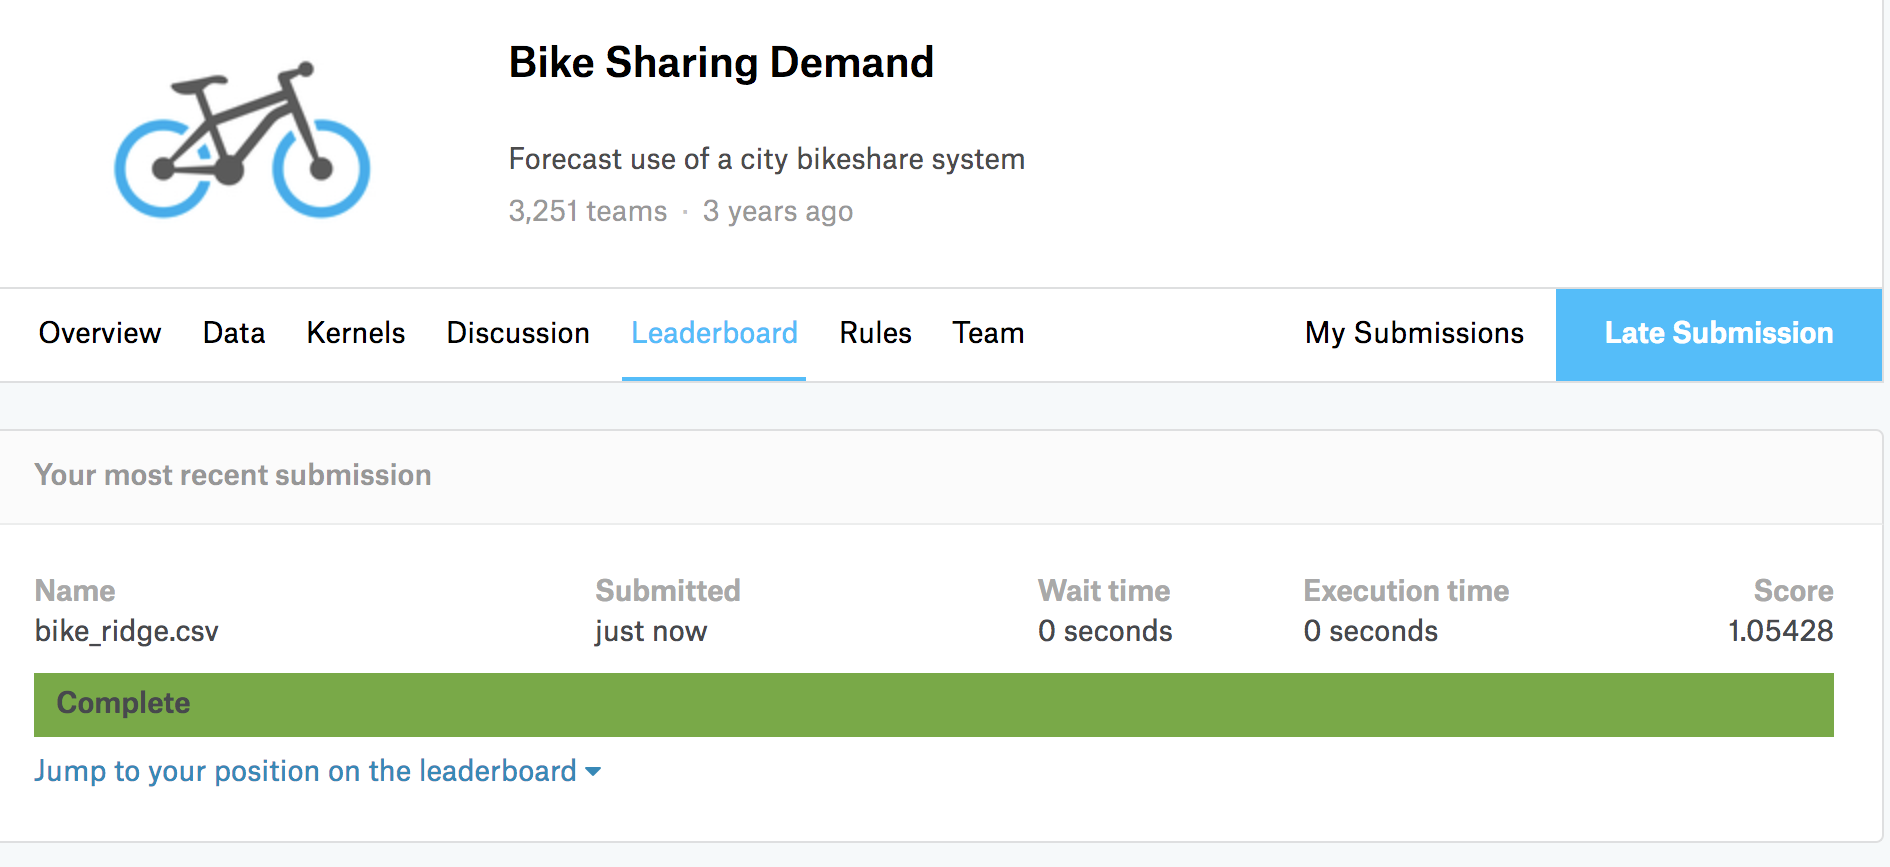

The Kaggle score with Ridge regression is not as good as the Kbest.

### Lasso Regression

In [846]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.3)
lasso_reg.fit(X_train_std[:, best_subset], y_train)

Lasso(alpha=0.3, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [847]:
#Calculate stuff for metrics
y_train_pred_int = lasso_reg.predict(X_train_std[:, best_subset])
train_time = time.time()-start

start = time.time()
y_test_pred_int = lasso_reg.predict(X_test_std[:, best_subset])
test_time = time.time()-start

In [848]:
y_train_pred = np.exp(y_train_pred_int) - 1
y_train_pred

array([ 68.77931808, 189.98350095, 160.59159815, ..., 114.45329335,
        72.78742401,  70.15347076])

In [849]:
y_test_pred = np.exp(y_test_pred_int) - 1
y_test_pred 

array([127.31530115,  49.82387193, 126.22049762, ..., 114.46565956,
        50.39416043, 119.10932357])

In [850]:

#Root_Mean_Square_Log_Error(RMSE) is accuracy criteria for this problem
# errors on  count
print('RMSE train: %.3f' % np.sqrt(mean_squared_error(y_train+1, y_train_pred+1)))
print('RMSE test: %.3f' % np.sqrt(mean_squared_error(y_test + 1, y_test_pred)))
print('R2 train: %.3f' % r2_score(y_train+1, y_train_pred))
print('R2 test: %.3f' % r2_score(y_test+1, y_test_pred))
print("MAE train: %.3f" % mean_absolute_error(y_train+1, y_train_pred))
print("MAE test: %.3f" % mean_absolute_error(y_test, y_test_pred))
print("MAPE train: %.3f" % mean_absolute_percentage_error(y_train, y_train_pred))
print("MAPE test: %.3f" % mean_absolute_percentage_error(y_test, y_test_pred))   

RMSE train: 121.342
RMSE test: 119.756
R2 train: -7240.640
R2 test: -6965.908
MAE train: 106.522
MAE test: 106.834
MAPE train: 2410.018
MAPE test: 2404.917


In [851]:
expLog.loc[len(expLog)] = ["SKLearn Lasso Regression (count)",
                           np.round(np.sqrt(mean_squared_error(y_train, y_train_pred)),3),
                           np.round(r2_score(y_train, y_train_pred), 3),
                           np.round(mean_absolute_error(y_train, y_train_pred), 3),
                           np.round(mean_absolute_percentage_error(y_train, y_train_pred),3),    
                           train_time,
                           np.round(np.sqrt(mean_squared_error(y_test, y_test_pred)),3),
                           np.round(r2_score(y_test+1, y_test_pred), 3),                       
                           np.round(mean_absolute_error(y_test, y_test_pred), 3),
                           np.round(mean_absolute_percentage_error(y_test, y_test_pred),3),
                           test_time]
expLog

,Model description,RMSE train,R2 Train,MAE train,MAPE train,Train Time,RMSE test,R2 test,MAE test,MAPE test,Test Time
0,SKLearn Linear Regression vanilla,140.858,0.398,105.685,339.812000,0.002435,140.211,0.395,105.622,355.454000,0.000162
1,SKLearn Decision Tree,0.276,1.000,0.007,0.047000,0.037741,62.105,0.881,36.238,37.833000,0.000919
2,SKLearn Random Forest,14.955,0.993,9.161,11.024000,4.524797,42.532,0.944,26.043,31.302000,0.206483
3,SKLearn KBest LR,140.872,0.398,105.573,339.399000,323.992354,297.788,-1.952,245.430,381.917000,0.001200
4,"SKLearn KBest LR, k=7",141.953,0.388,106.298,336.122000,119.289571,237.734,-0.893,190.769,290.431000,0.001422
5,"SKLearn KBest LR, k=7",123.045,0.342,89.069,inf,9.615397,121.995,0.334,89.074,inf,0.001272
6,SKLearn KBest LR (Registered),123.045,0.342,89.069,inf,9.615397,121.995,0.334,89.074,inf,0.001272
7,SKLearn KBest LR (Casual),35.981,0.477,24.410,inf,27.386402,36.332,0.481,24.491,inf,0.000968
8,SKLearn SBS Count log,102.747,-5267.819,97.596,2343.399000,1479.635973,102.521,-5010.796,97.418,2358.299000,0.000382
9,SKLearn Ridge Regression (count),193.124,-18613.230,144.022,2907.697000,2388.006037,190.216,-17438.615,141.807,2867.776000,0.000570


** Ignore row 5

#### Fit the model using entire data

In [852]:
X.head()

,holiday,workingday,temp,atemp,humidity,windspeed,weather1,weather2,weather3,weather4,season1,season2,season3,season4,hour,day,month,year
0,0,0,9.84,14.395,81,0.0,1,0,0,0,1,0,0,0,0,5,1,0
1,0,0,9.02,13.635,80,0.0,1,0,0,0,1,0,0,0,1,5,1,0
2,0,0,9.02,13.635,80,0.0,1,0,0,0,1,0,0,0,2,5,1,0
3,0,0,9.84,14.395,75,0.0,1,0,0,0,1,0,0,0,3,5,1,0
4,0,0,9.84,14.395,75,0.0,1,0,0,0,1,0,0,0,4,5,1,0


In [853]:
#bestX_feat = X.drop(['weather3','season2'], axis = 1)
X_standard = sc.fit_transform(X)
X_standard=X_standard[:, best_subset]

In [854]:
lasso_reg.fit(X_standard,y) #X_train_std[:, best_subset]

Lasso(alpha=0.3, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

#### Let's predict!

In [855]:
test_1=pd.read_csv('./Kaggle-Bike-Sharing-Demand-Challenge/test.csv')
test_1.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [856]:
### Dont forget to Generate features and 


# Create a new column called df.weather1 where the value is 1
# if df.weather is 1 and 0 if not
test_1['weather1'] = np.where(test_1['weather']==1, 1, 0)  #ifelse assignment
test_1['weather2'] = np.where(test_1['weather']==2, 1, 0)
test_1['weather3'] = np.where(test_1['weather']==3, 1, 0)
test_1['weather4'] = np.where(test_1['weather']==4, 1, 0)

# dont forget to drop the original feature
test_1.drop(['weather'], axis=1, inplace=True)

test_1['season1'] = np.where(test_1['season']==1, 1, 0)  #ifelse assignment
test_1['season2'] = np.where(test_1['season']==2, 1, 0)
test_1['season3'] = np.where(test_1['season']==3, 1, 0)
test_1['season4'] = np.where(test_1['season']==4, 1, 0)
test_1.drop(['season'], axis=1, inplace=True)


test_1["hour"] = [t.hour for t in pd.DatetimeIndex(test_1.datetime)]
test_1["day"] = [t.dayofweek for t in pd.DatetimeIndex(test_1.datetime)]
test_1["month"] = [t.month for t in pd.DatetimeIndex(test_1.datetime)]
test_1['year'] = [t.year for t in pd.DatetimeIndex(test_1.datetime)]
test_1['year'] = test_1['year'].map({2011:0, 2012:1})


X_test1=test_1.iloc[:,1:]

X_test1.head(10)

,holiday,workingday,temp,atemp,humidity,windspeed,weather1,weather2,weather3,weather4,season1,season2,season3,season4,hour,day,month,year
0,0,1,10.66,11.365,56,26.0027,1,0,0,0,1,0,0,0,0,3,1,0
1,0,1,10.66,13.635,56,0.0000,1,0,0,0,1,0,0,0,1,3,1,0
2,0,1,10.66,13.635,56,0.0000,1,0,0,0,1,0,0,0,2,3,1,0
3,0,1,10.66,12.880,56,11.0014,1,0,0,0,1,0,0,0,3,3,1,0
4,0,1,10.66,12.880,56,11.0014,1,0,0,0,1,0,0,0,4,3,1,0
5,0,1,9.84,11.365,60,15.0013,1,0,0,0,1,0,0,0,5,3,1,0
6,0,1,9.02,10.605,60,15.0013,1,0,0,0,1,0,0,0,6,3,1,0
7,0,1,9.02,10.605,55,15.0013,1,0,0,0,1,0,0,0,7,3,1,0
8,0,1,9.02,10.605,55,19.0012,1,0,0,0,1,0,0,0,8,3,1,0
9,0,1,9.84,11.365,52,15.0013,0,1,0,0,1,0,0,0,9,3,1,0


In [857]:
X_test1_standard = sc.transform(X_test1)

In [858]:
X_test1_standard = X_test1_standard[:, best_subset]
y_f_pred =lasso_reg.predict(X_test1_standard)
print("Predictions:", y_f_pred)

Predictions: [3.57144693 3.6833967  3.75257341 ... 5.04585952 5.13610745 5.18988304]


In [859]:
y_f_pred_in_log = np.exp(y_f_pred) - 1
print("Predictions:", y_f_pred_in_log)

Predictions: [ 34.5680203   38.78129008  41.6306469  ... 154.37779227 169.0525402
 178.44756295]


In [860]:
df_submit_lass = test

df_submit_lass['count'] = np.round(y_f_pred_in_log)

In [861]:
df_submit_lass.head(10)

,datetime,holiday,workingday,temp,atemp,humidity,windspeed,weather1,weather2,weather3,weather4,season1,season2,season3,season4,hour,day,month,year,count
0,2011-01-20 00:00:00,0,1,10.66,11.365,56,26.0027,1,0,0,0,1,0,0,0,0,3,1,0,35.0
1,2011-01-20 01:00:00,0,1,10.66,13.635,56,0.0000,1,0,0,0,1,0,0,0,1,3,1,0,39.0
2,2011-01-20 02:00:00,0,1,10.66,13.635,56,0.0000,1,0,0,0,1,0,0,0,2,3,1,0,42.0
3,2011-01-20 03:00:00,0,1,10.66,12.880,56,11.0014,1,0,0,0,1,0,0,0,3,3,1,0,44.0
4,2011-01-20 04:00:00,0,1,10.66,12.880,56,11.0014,1,0,0,0,1,0,0,0,4,3,1,0,47.0
5,2011-01-20 05:00:00,0,1,9.84,11.365,60,15.0013,1,0,0,0,1,0,0,0,5,3,1,0,49.0
6,2011-01-20 06:00:00,0,1,9.02,10.605,60,15.0013,1,0,0,0,1,0,0,0,6,3,1,0,52.0
7,2011-01-20 07:00:00,0,1,9.02,10.605,55,15.0013,1,0,0,0,1,0,0,0,7,3,1,0,56.0
8,2011-01-20 08:00:00,0,1,9.02,10.605,55,19.0012,1,0,0,0,1,0,0,0,8,3,1,0,60.0
9,2011-01-20 09:00:00,0,1,9.84,11.365,52,15.0013,0,1,0,0,1,0,0,0,9,3,1,0,66.0


In [862]:
df_submit_lass = df_submit_lass.drop(['season1', 'season2', 'season3','season4', 'holiday', 'workingday','temp', 'atemp', 
                                    'humidity', 'windspeed', 'hour', 'day', 'month', 'year', 'weather1', 'weather2', 'weather3',
                                    'weather4'], axis=1)

df_submit_lass.head()

,datetime,count
0,2011-01-20 00:00:00,35.0
1,2011-01-20 01:00:00,39.0
2,2011-01-20 02:00:00,42.0
3,2011-01-20 03:00:00,44.0
4,2011-01-20 04:00:00,47.0


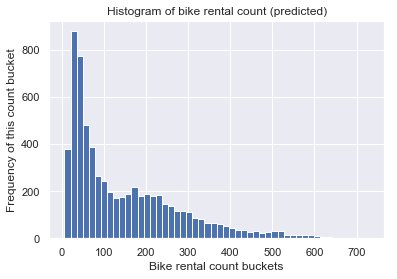

In [863]:
## check neg results
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import math

# the histogram of the data
n, bins, patches = plt.hist(df_submit_rr['count'], 50)

plt.xlabel('Bike rental count buckets')
plt.ylabel('Frequency of this count bucket')
plt.title(r'Histogram of bike rental count (predicted)')
plt.grid(True)

plt.show()

Looks good!

In [864]:
df_submit_lass.to_csv("bike_lasso.csv", index=False)

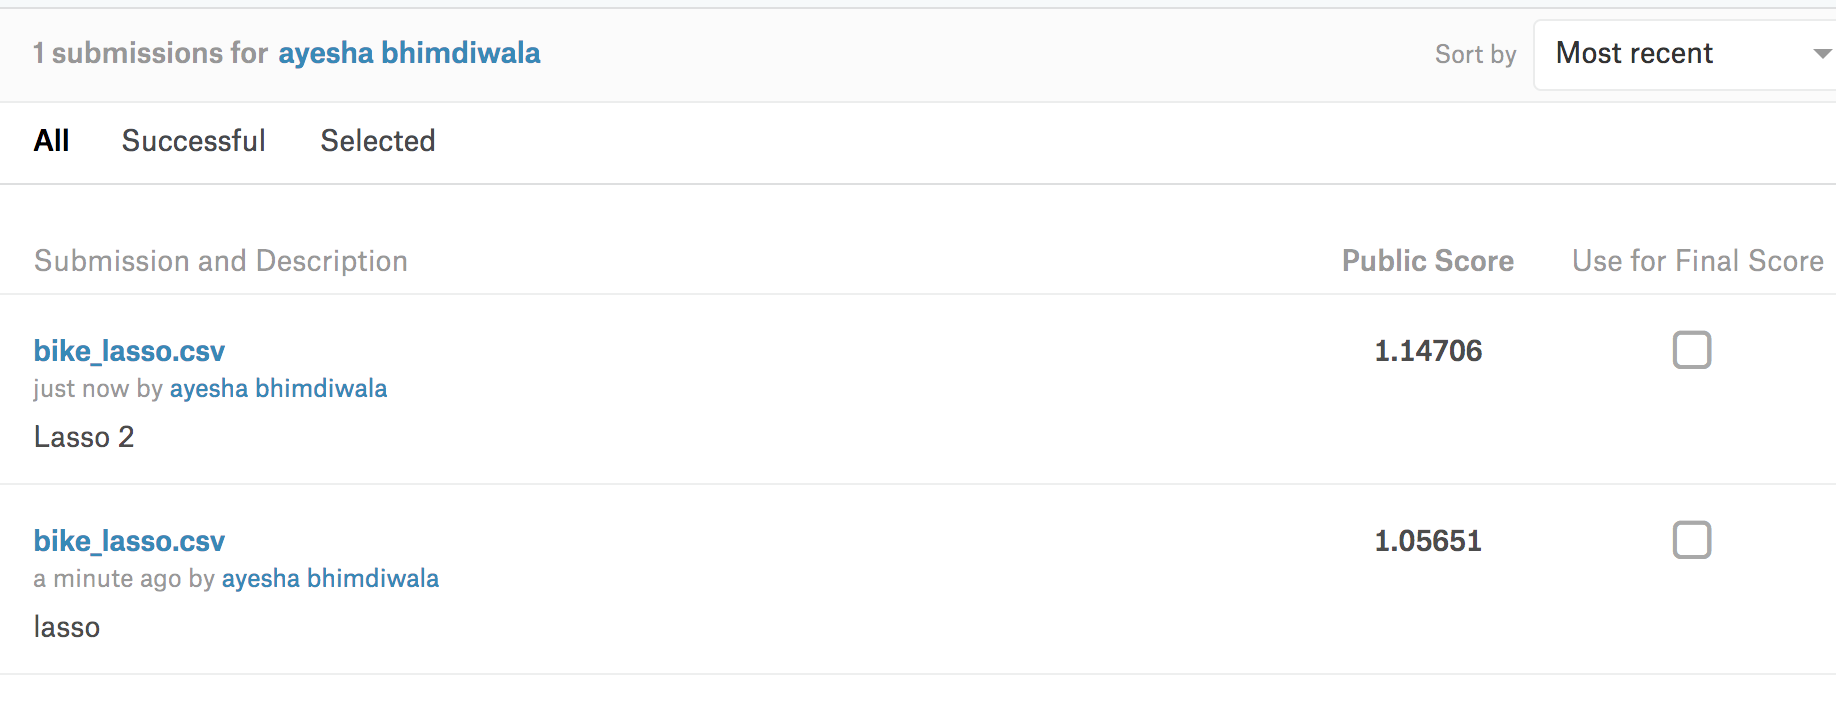

With alpha = 0.1 and alpha = 0.3, I got a score of 1.056 and 1.147 respectively. 